# Desafio DataLab

### Santander Customer Transaction Prediction

* The task is to predict the value of target column in the test set.
* "Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target."

* This notebook contains the following steps:

    - Feature analysis;
    - Benchmar model;
    - Feature selection;
    - Hyperparameter tunning;
    - Model evaluation and selection.
    

## Index

[Libs](#Libs)

[Carregando o Dataset](#Carregando-o-Dataset)

[Função Metadados](#Função-Metadados)

[Metadados DataFrame](#Metadados-DataFrame)

[Verificação da qualidade dos dados disponibilizados no dataset](#Verificação-da-qualidade-dos-dados-disponibilizados-no-dataset)

[Dividindo o Dataset em treino e teste](#Dividindo-o-Dataset-em-treino-e-teste)

[Benchmark](#Benchmark)

[Modelo com todas as variáveis, sem modificações no dataset](#Modelo-com-todas-as-variáveis,-sem-modificações-no-dataset)

[Sampling Dataset](#Sampling-Dataset)

[Resampling](#Resampling)

[Distribuição das variáveis em relação ao evento](#Distribuição-das-variáveis-em-relação-ao-evento)

[Normalização das Variáveis](#Normalização-das-Variáveis)

[Modelo](#Modelo)

[Modelo com dataset balanceado - df_sampled](#Modelo-com-dataset-balanceado---df_sampled)

[Modelo com dataset balanceado - df_resamp](#Modelo-com-dataset-balanceado---df_resamp)

[Teste de importância das variáveis](#Teste-de-importância-das-variáveis)

[Correlação das variáveis](#Correlação-das-variáveis)

[Função para inclusão das variáveis](#Função-para-inclusão-das-variáveis)

[Visualização do resultado da inclusão das variáveis](#Visualização-do-resultado-da-inclusão-das-variáveis)

[Modelo com o número de variáveis otimizado](#Modelo-com-o-número-de-variáveis-otimizado)

[Otimização dos parâmetros do modelo de reg. logística](#Otimização-dos-parâmetros-do-modelo-de-reg.-logística)

[Resultados do processo de otimização](#Resultados-do-processo-de-otimização)

[XGBoost - Extreme Gradient Boosting](#XGBoost---Extreme-Gradient-Boosting)

[Treinando o modelo com a amostra do dataset normalizada - df_norm](#Treinando-o-modelo-com-a-amostra-do-dataset-normalizada---df_norm)

[Treinando o modelo com dataset balanceado](#Treinando-o-modelo-com-dataset-balanceado)

[Escolha dos melhores parâmetros para o modelo](#Escolha-dos-melhores-parâmetros-para-o-modelo)

[Seleção das variáveis - XGB](#Seleção-das-variáveis---XGB)

[Resultados do processo de otimização - XGB](#Resultados-do-processo-de-otimização---XGB)

[Resultados consolidados](#Resultados-consolidados)

[Métricas Obtidas](#Métricas-Obtidas)

[Considerações Finais](#Considerações-Finais)

# Libs

[Index](#Index)

In [18]:
import numpy as np
import pandas as pd
import os
import time
import math
import warnings

warnings.filterwarnings('ignore')

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Defining work directory

In [19]:
os.chdir('/Users/caio/Documents/Teste_DataLab') 

In [20]:
os.getcwd() # confirmação 

'/Users/caio/Documents/Teste_DataLab'

### Carregando o Dataset

[Índice](#Índice)

In [21]:
df_raw = pd.read_csv('train.csv')

print ('Dimensões do Dataset:')
print ()
print (df_raw.shape)

Dimensões do Dataset:

(200000, 202)


In [22]:
df_raw.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   ...     var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266   ...      4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338   ...      7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155   ...      2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250   ...      4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514   ...     -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [23]:
# Lista das variáveis do Dataset
vars = list(df_raw.columns[2:]) 

## Função Metadados

* Função para obtenção dos Metadados do Dataset

[Índice](#Índice)

[Metadados DataFrame](#Metadados-DataFrame)

In [24]:
def Metadados(dataframe): 

    train = dataframe

    missing = []
    data = []
    for f in train.columns:

        missing=train[f].isnull().sum()
        
        # Definindo o papel das variáveis:
        if f in ['target','COMPROU','CHURN','CONTRAT']: #Variável Resposta
            role = 'target'
        elif f in ['ID_code','id','ID','ccpf_cnpj','CCPF_CNPJ','CD_Agencia','CD_Conta']:
            role = 'id'          
        else:
            role = 'input'

        # Definindo o tipo das variáveis:
        if f == 'target': #Neste caso específico
            level = 'binary'
        elif train[f].dtype == 'object' or f == 'id': 
            level = 'nominal'
        elif (train[f].dtype in ['float','float64'] and train[f].value_counts().shape[0] > 2):
            level = 'interval'
        elif (train[f].dtype in ['float','float64'] and train[f].value_counts().shape[0] == 2):
            level = 'binary'
        elif (train[f].dtype in ['float','float64'] and train[f].value_counts().shape[0] < 2):
            level = 'constant'            
        elif train[f].dtype in ['int','int64'] :
            level = 'ordinal'
        else:
            level = 'other'

        # Definindo o tipo das variáveis da tabela de entrada
        dtype = train[f].dtype

        # Criando a lista com todo metadados
        f_dict = {
            'Features': f,
            'Role': role,
            'Level': level,
            'Type': dtype,
            'Missing': missing
        }
        data.append(f_dict)

    meta = pd.DataFrame(data, columns=['Features', 'Role', 'Level', 'Type', 'Missing'])

    # Quantidade de domínios distintos para cada variável do tipo ordinal e nominal
    card = []

    v = train.columns
    for f in v:
        dist_values = train[f].value_counts().shape[0]
        f_dict = {
                'Features': f,
                'Cardinality': dist_values
            }
        card.append(f_dict)

    card = pd.DataFrame(card, columns=['Features', 'Cardinality'])

    metadados_train = pd.merge(meta, card, on='Features')

    return metadados_train 

## Metadados DataFrame

[Índice](#Índice)

[Função Metadados](#Função-Metadados)

In [25]:
Meta_raw = Metadados(df_raw)

In [26]:
Meta_raw.head(20)

Features    Role     Level     Type  Missing  Cardinality
0   ID_code      id   nominal   object        0       200000
1    target  target    binary    int64        0            2
2     var_0   input  interval  float64        0        94672
3     var_1   input  interval  float64        0       108932
4     var_2   input  interval  float64        0        86555
5     var_3   input  interval  float64        0        74597
6     var_4   input  interval  float64        0        63515
7     var_5   input  interval  float64        0       141029
8     var_6   input  interval  float64        0        38599
9     var_7   input  interval  float64        0       103063
10    var_8   input  interval  float64        0        98617
11    var_9   input  interval  float64        0        49417
12   var_10   input  interval  float64        0       128764
13   var_11   input  interval  float64        0       130193
14   var_12   input  interval  float64        0         9561
15   var_13   input  interval  float64        0       115181
16   var_14   input  interval  float64        0        79122
17   var_15   input  interval  float64        0        19810
18   var_16   input  interval  float64        0        86918
19   var_17   input  interval  float64        0       137823

## Verificação da qualidade dos dados disponibilizados no dataset

[Índice](#Índice)

In [27]:
#Formato das Variáveis no Dataset
Meta_raw.Level.unique()

array(['nominal', 'binary', 'interval'], dtype=object)

In [28]:
#Quantidade de 'missings' no Dataset
Meta_raw.Missing.unique()

array([0])

In [29]:
#Quantidade de 'missings' no Dataset
Meta_raw.Type.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [30]:
Meta_raw[Meta_raw.Type == 'int64']

Features    Role   Level   Type  Missing  Cardinality
1   target  target  binary  int64        0            2

In [31]:
Meta_raw[Meta_raw.Type == 'O']

Features Role    Level    Type  Missing  Cardinality
0  ID_code   id  nominal  object        0       200000

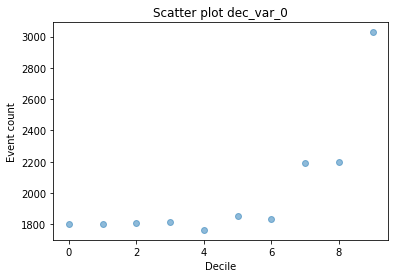

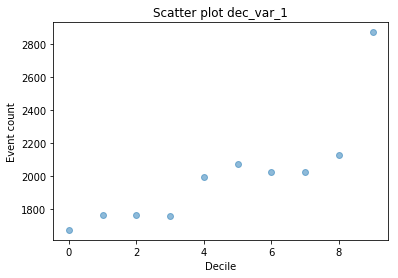

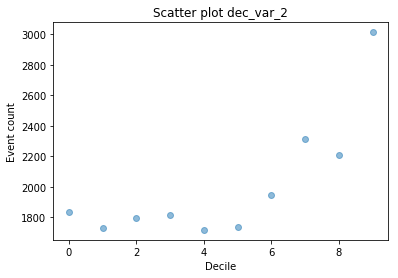

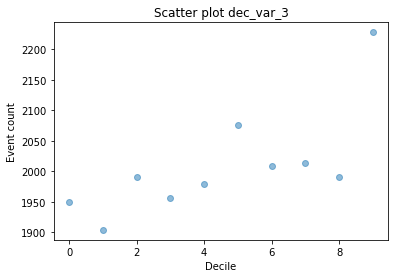

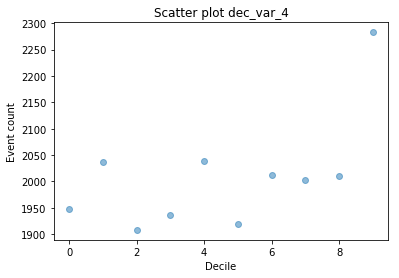

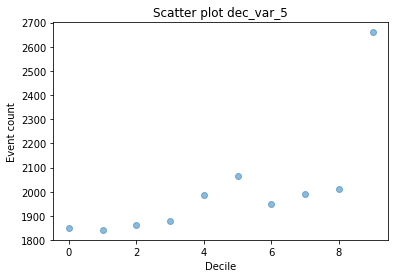

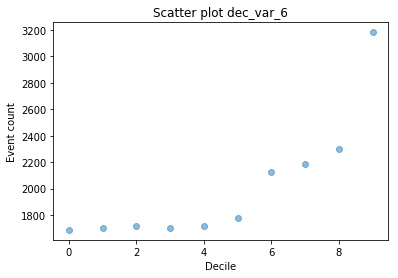

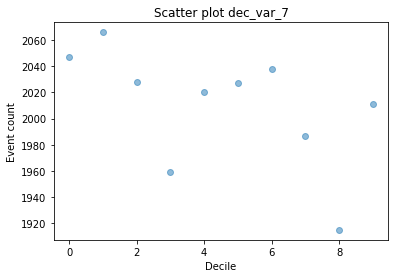

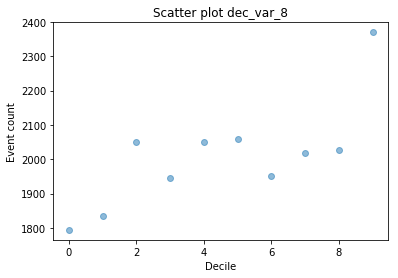

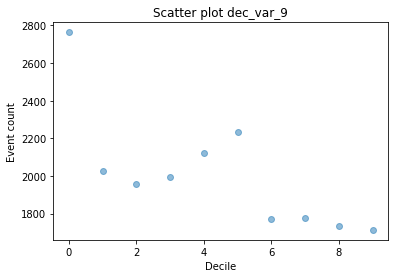

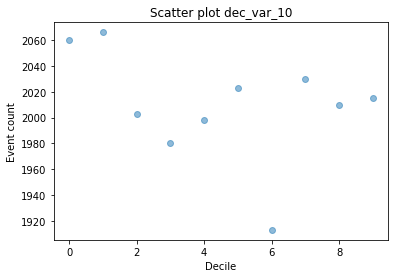

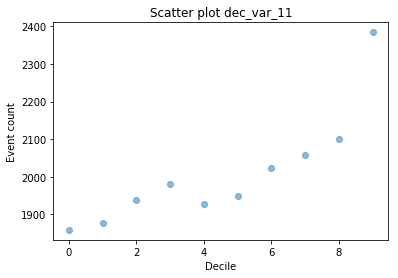

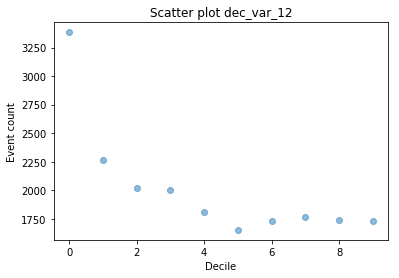

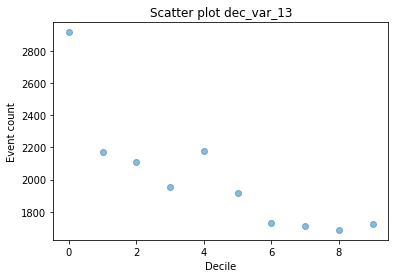

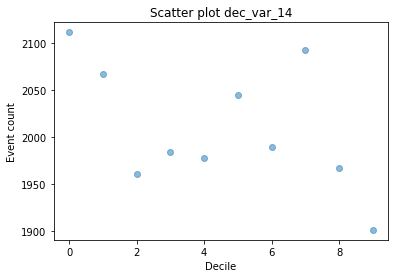

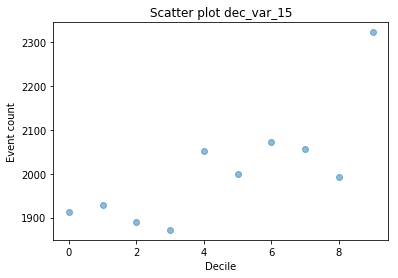

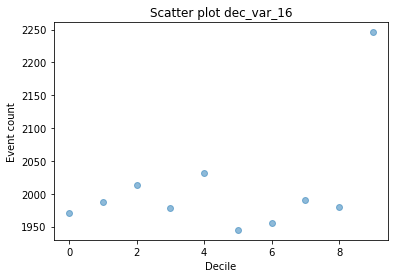

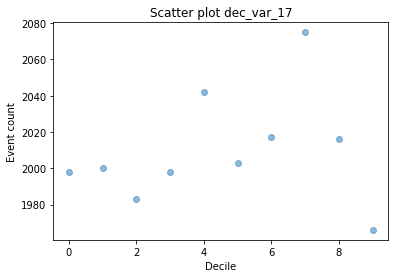

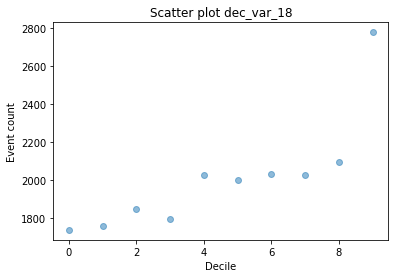

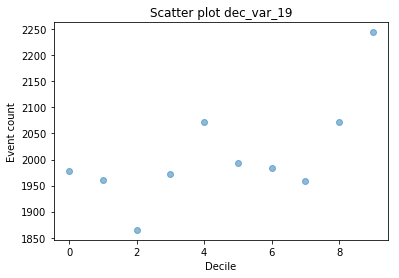

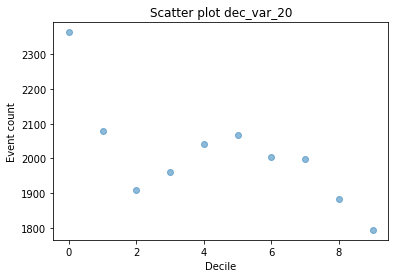

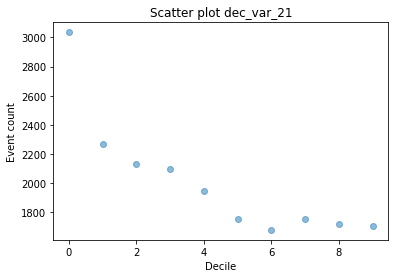

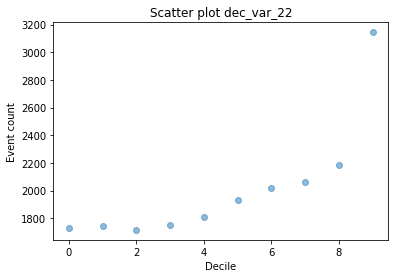

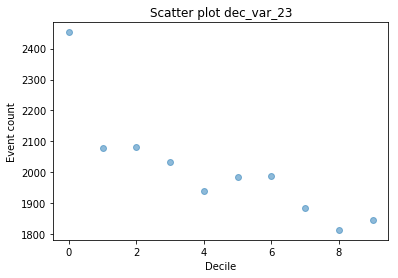

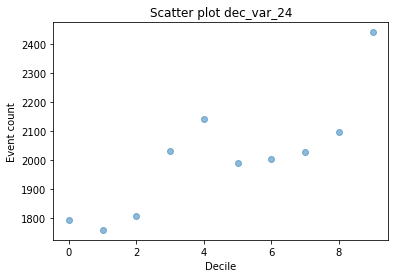

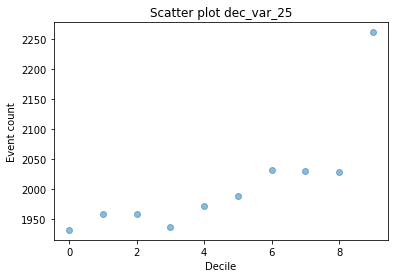

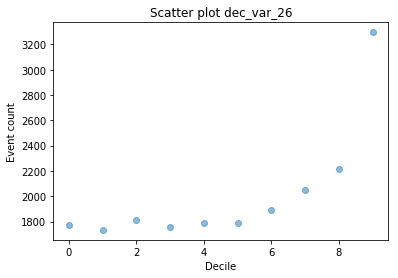

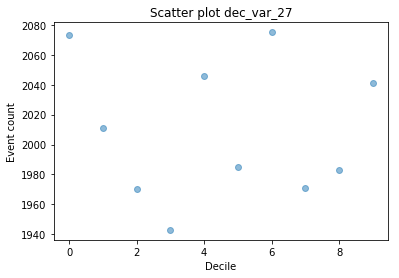

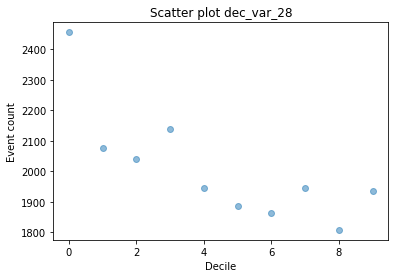

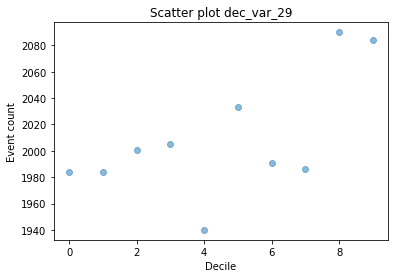

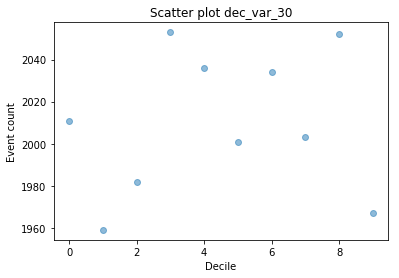

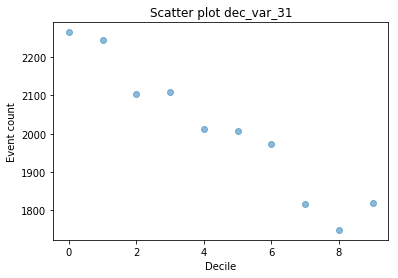

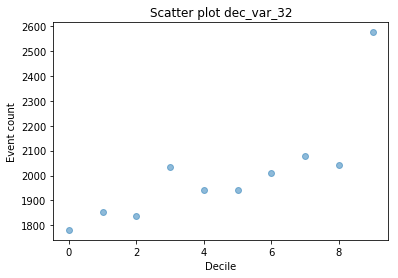

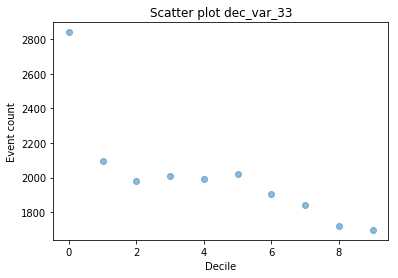

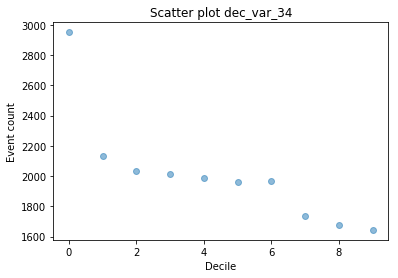

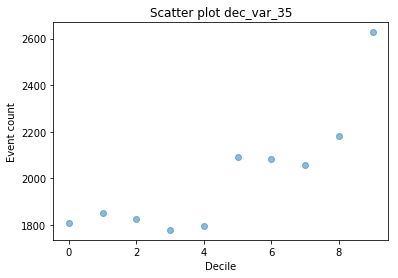

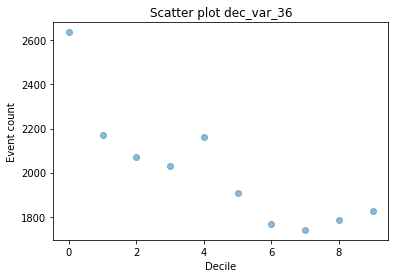

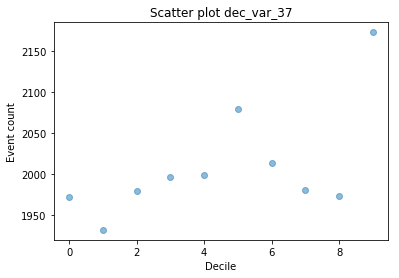

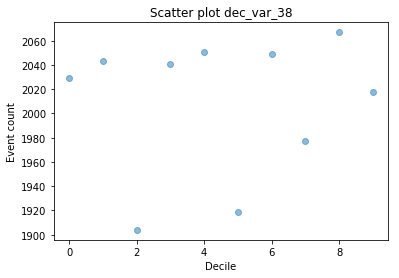

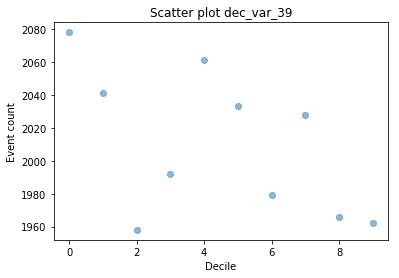

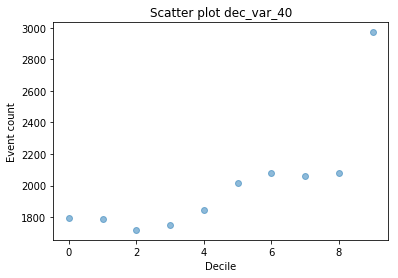

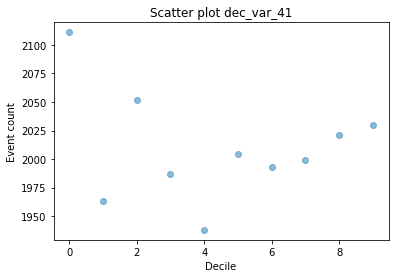

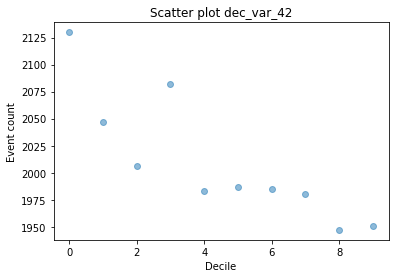

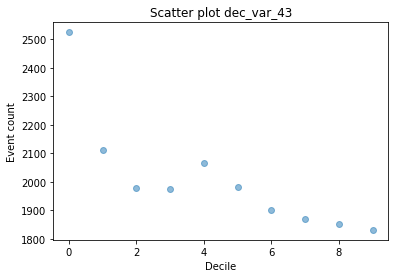

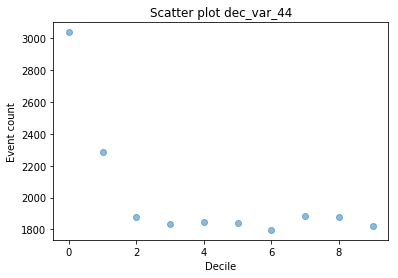

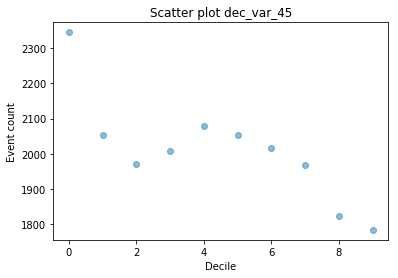

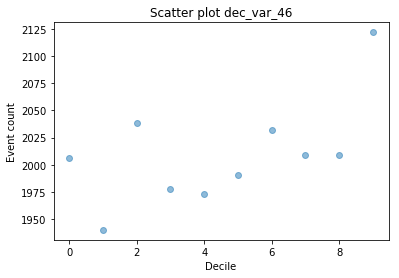

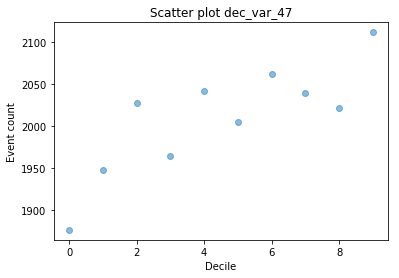

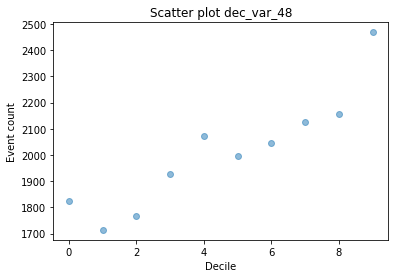

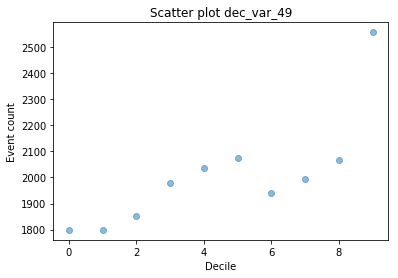

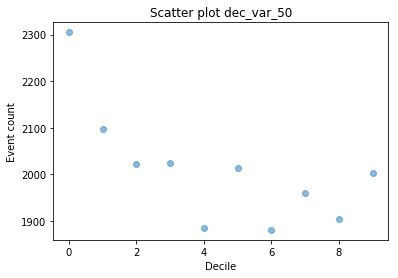

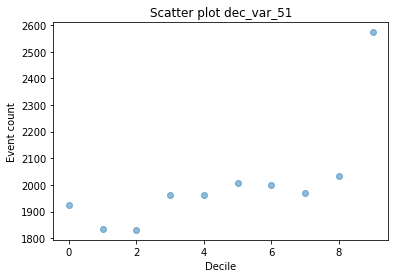

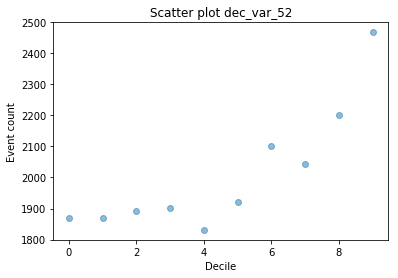

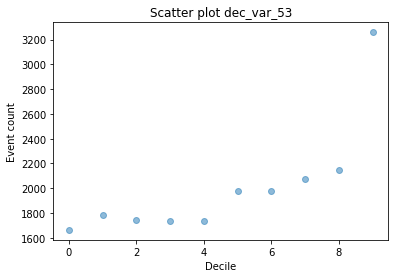

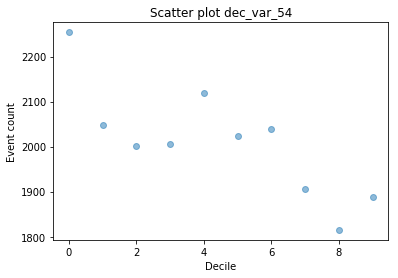

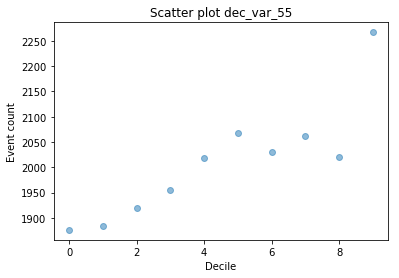

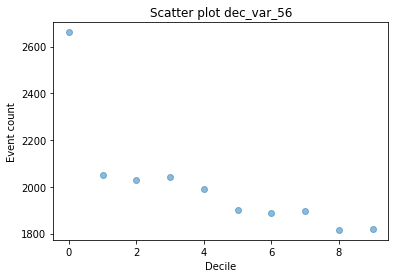

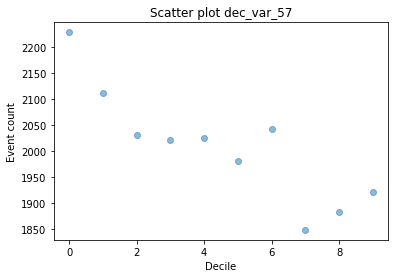

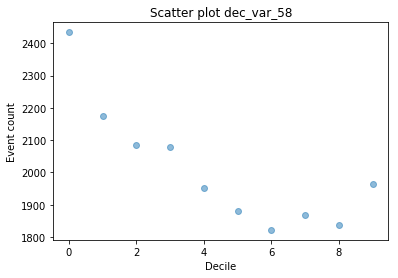

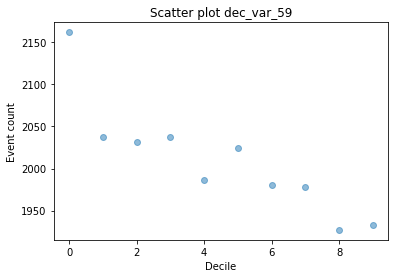

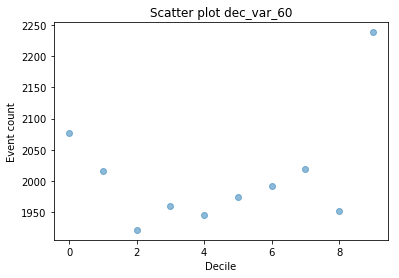

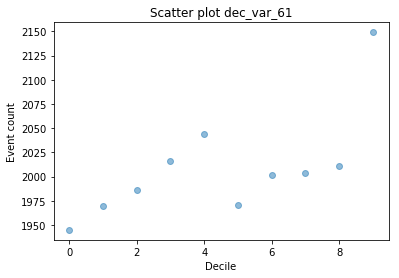

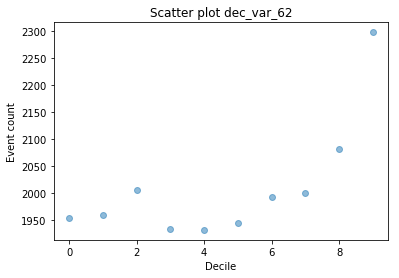

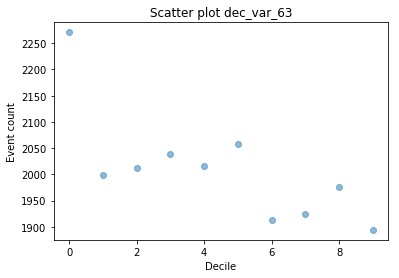

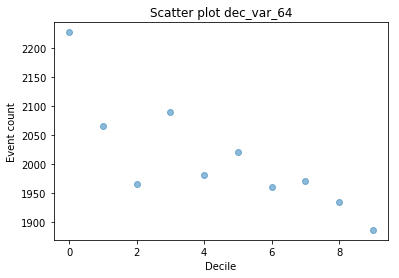

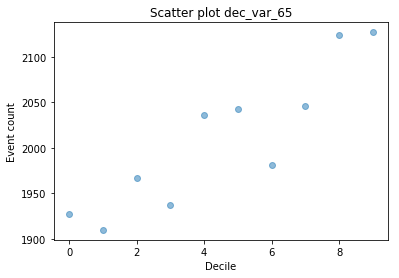

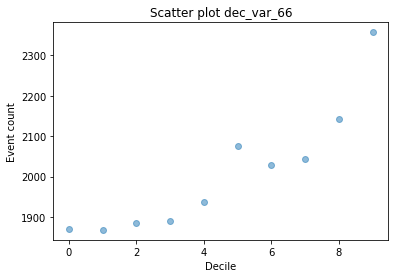

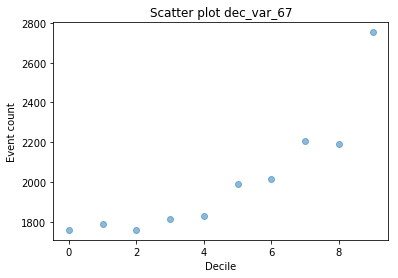

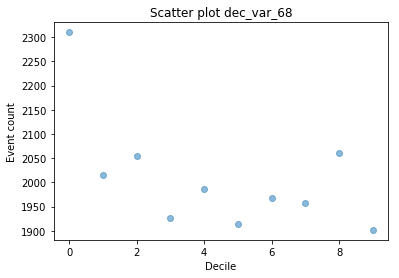

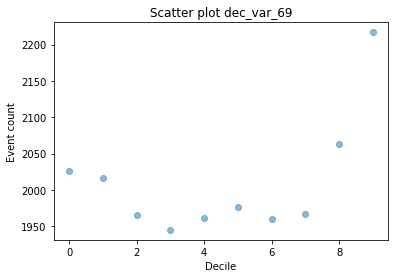

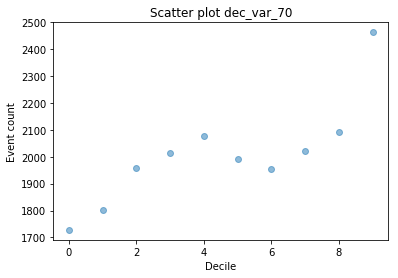

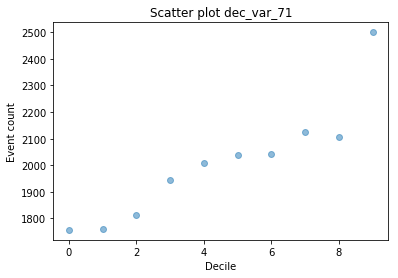

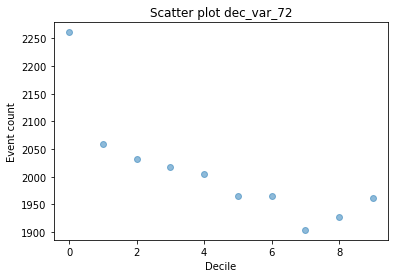

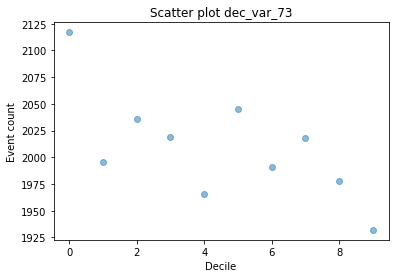

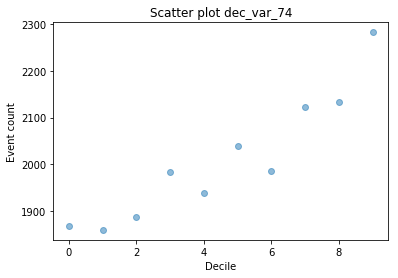

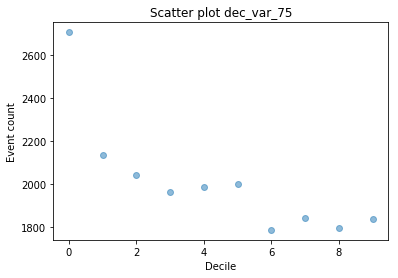

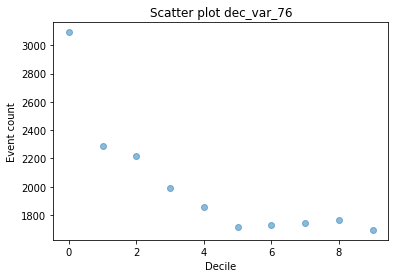

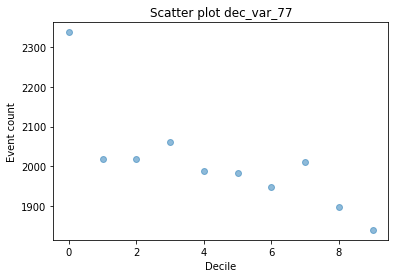

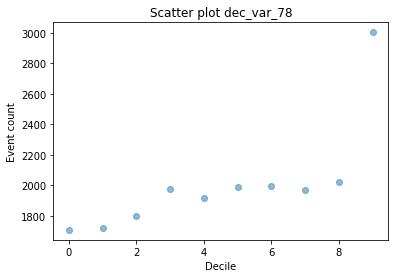

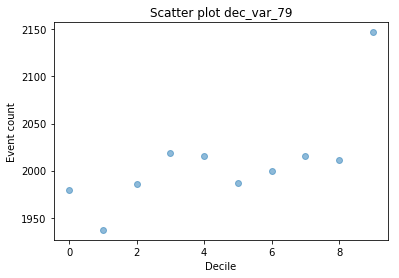

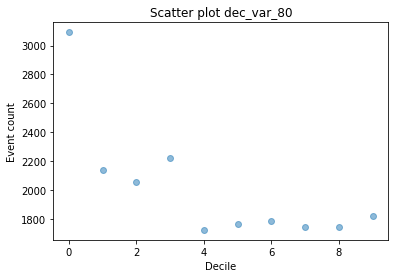

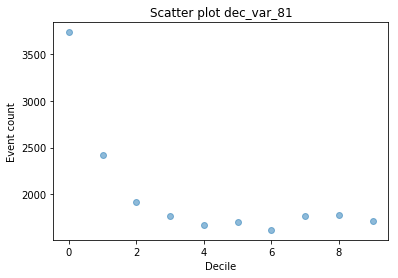

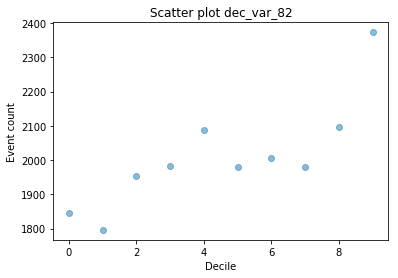

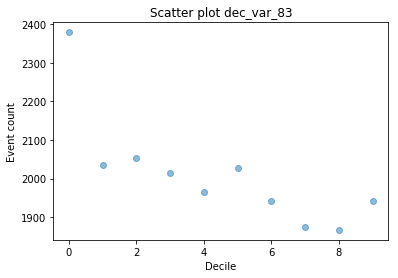

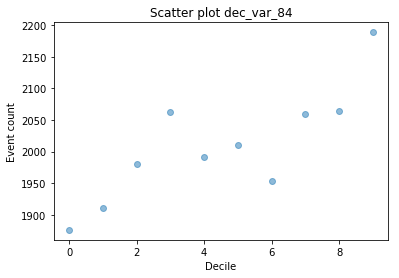

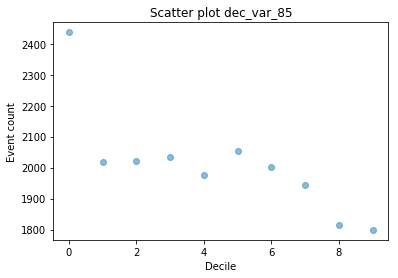

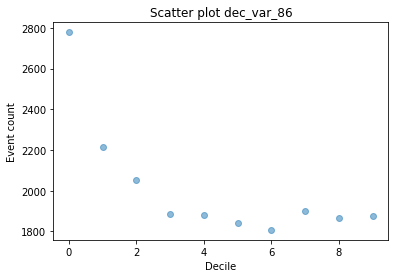

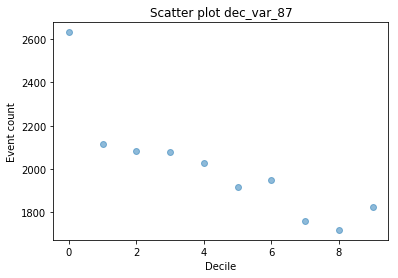

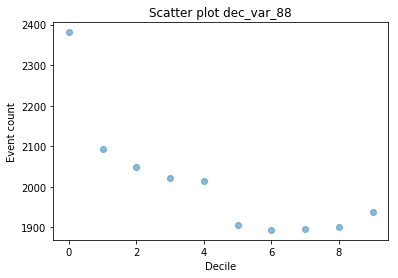

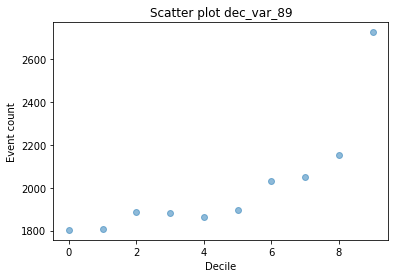

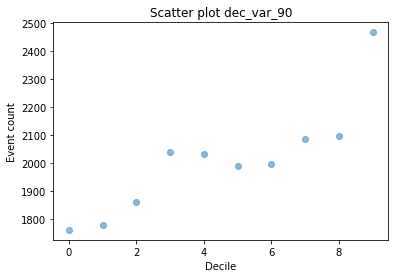

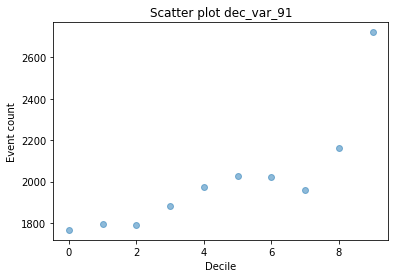

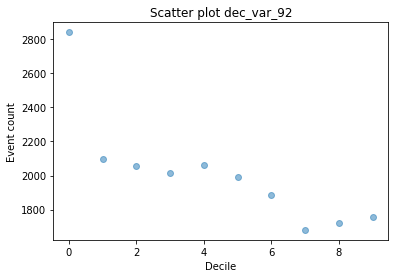

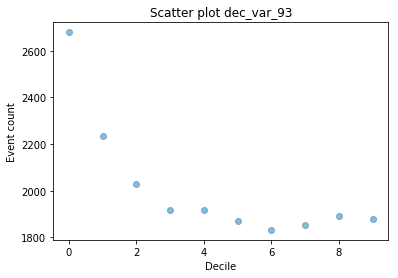

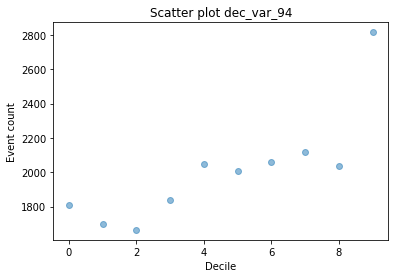

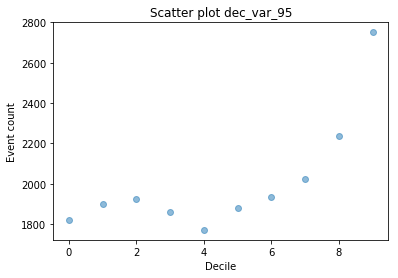

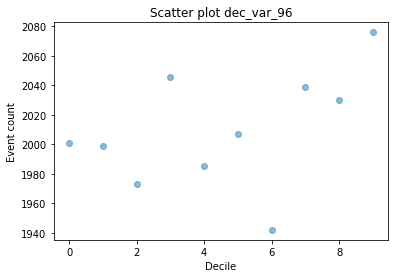

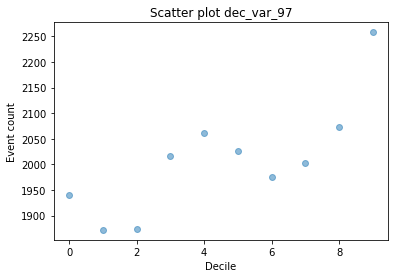

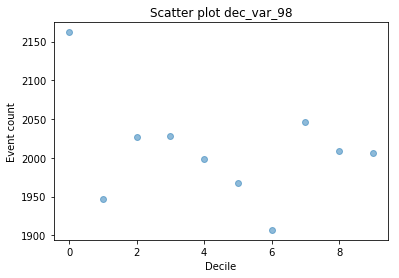

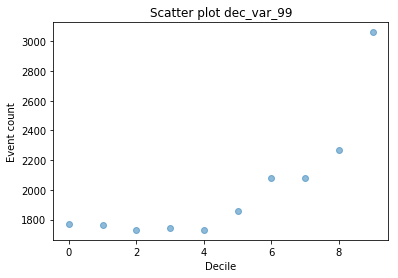

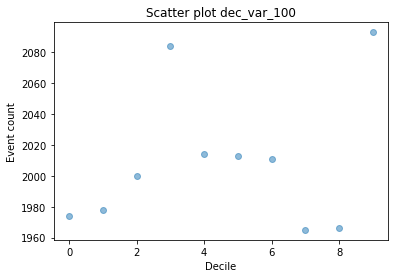

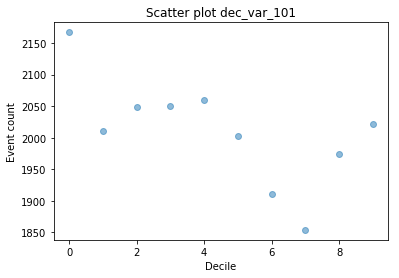

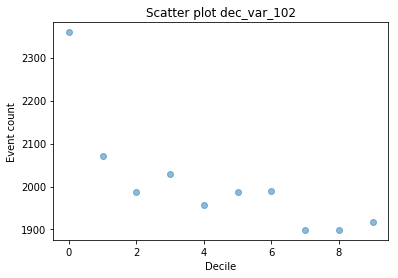

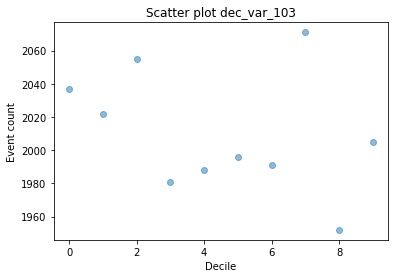

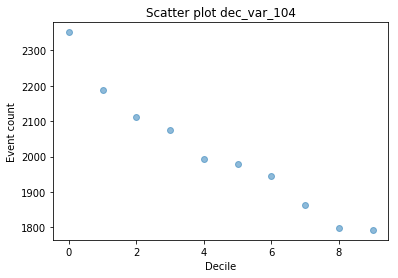

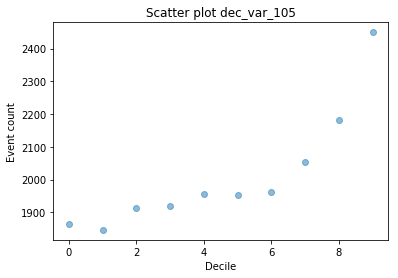

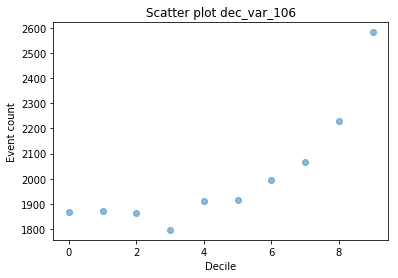

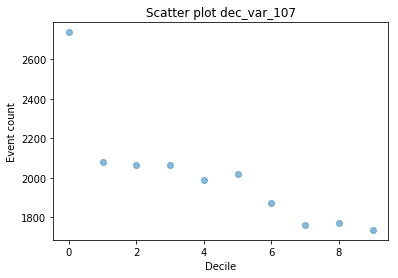

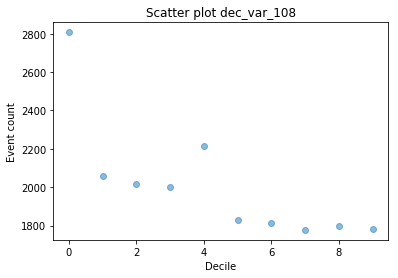

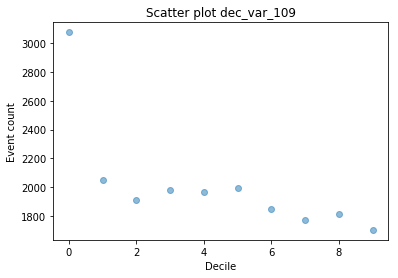

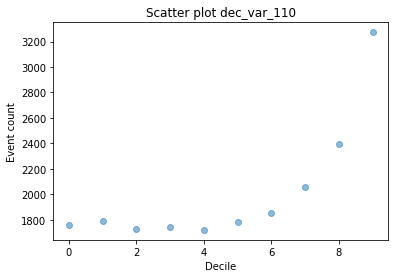

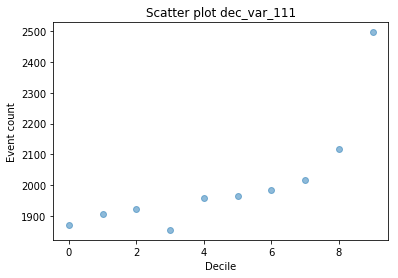

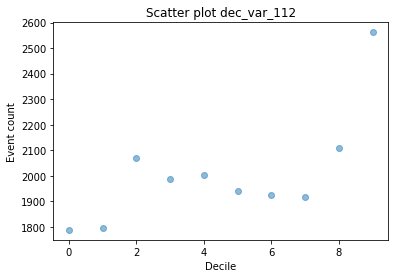

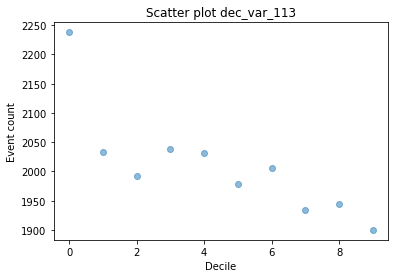

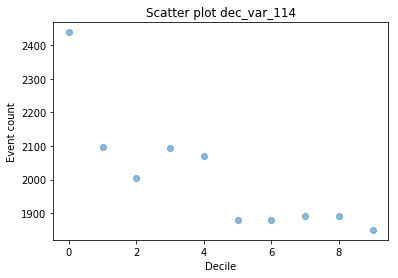

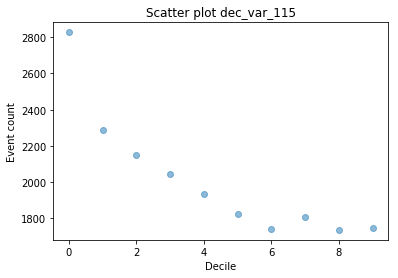

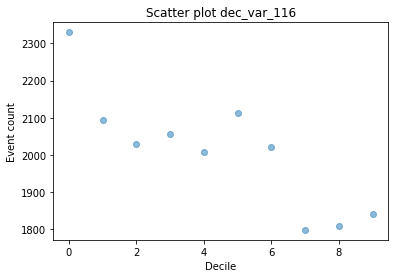

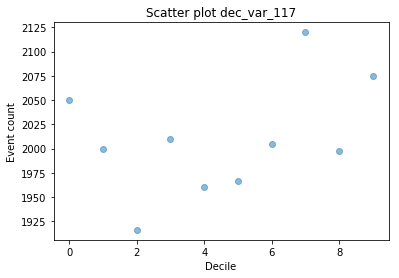

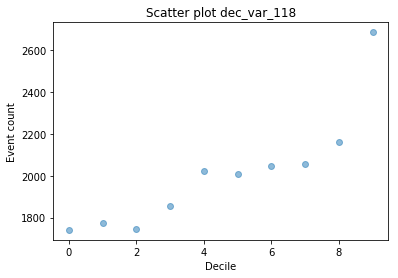

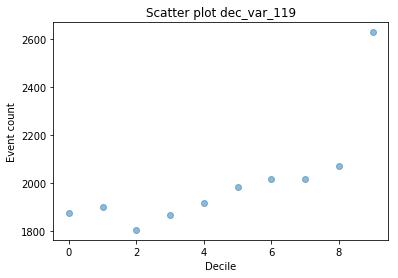

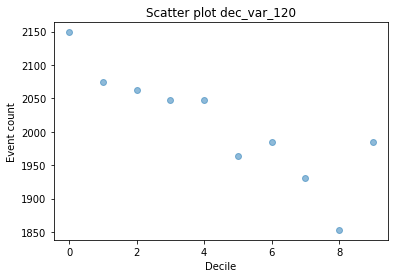

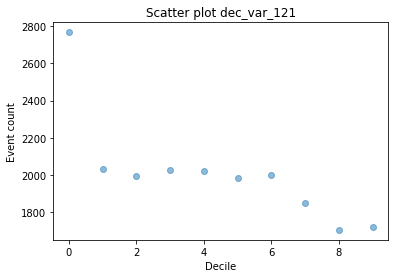

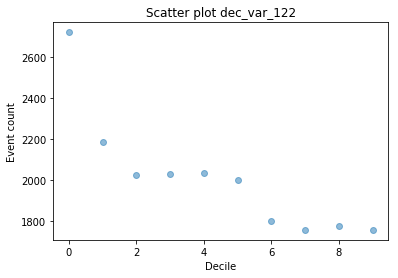

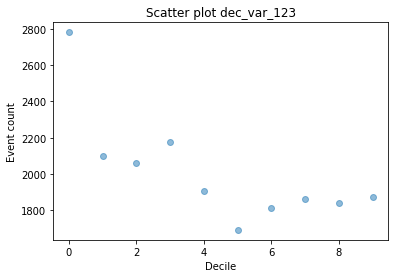

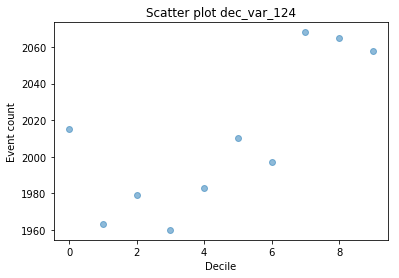

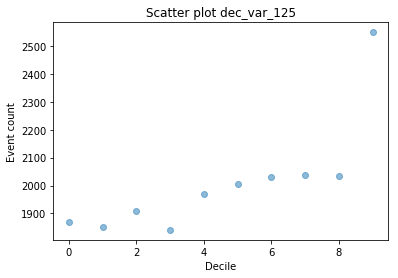

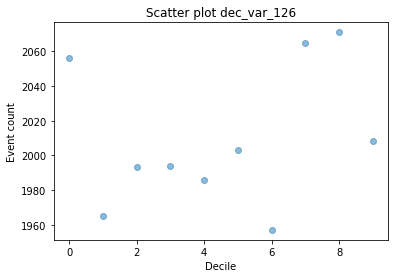

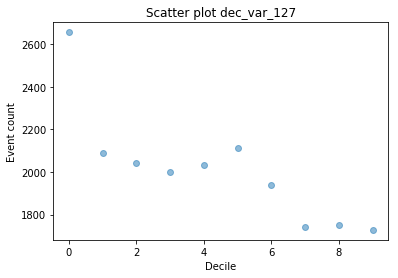

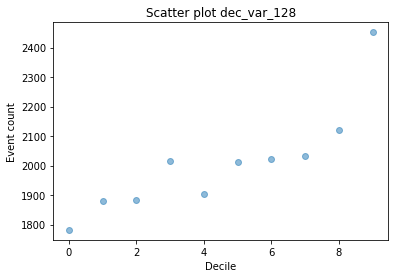

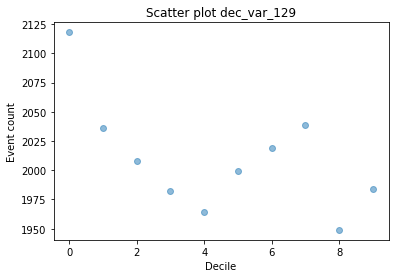

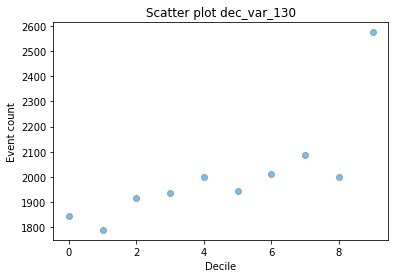

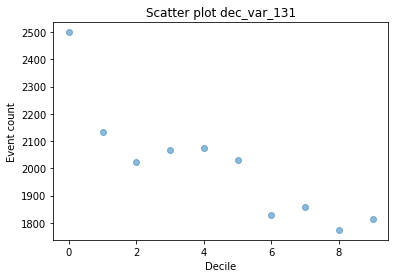

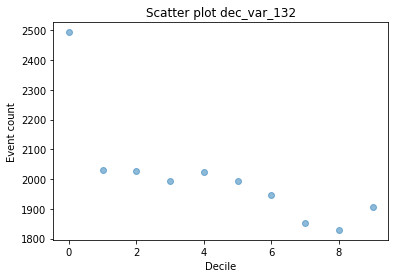

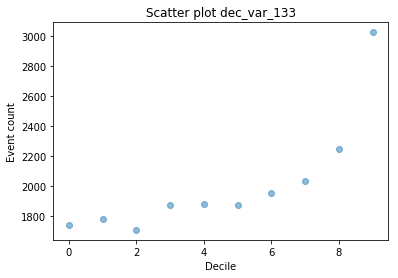

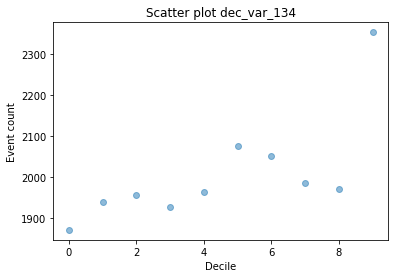

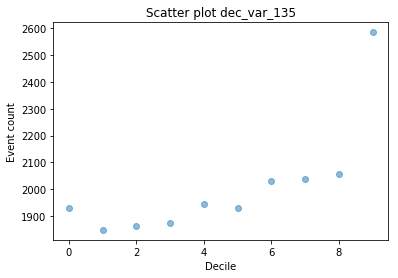

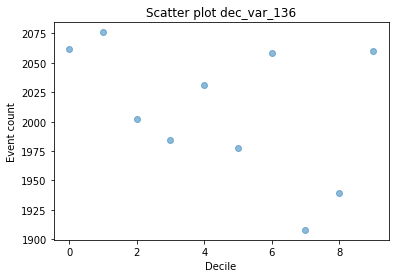

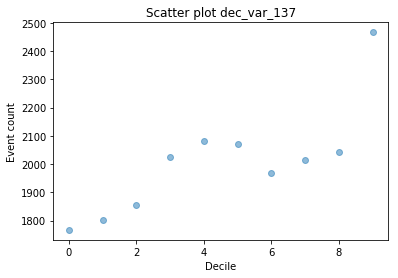

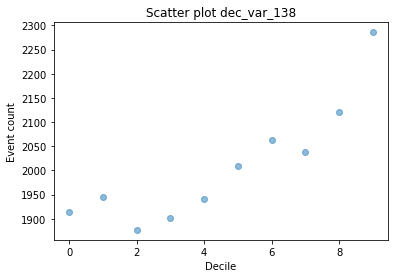

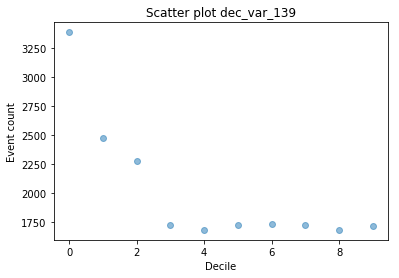

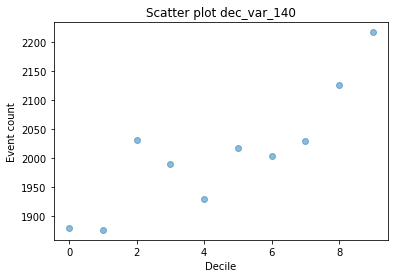

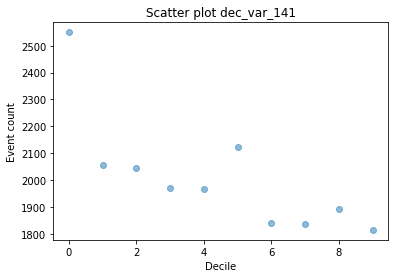

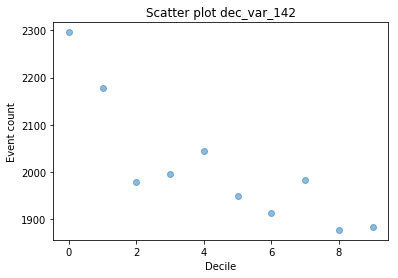

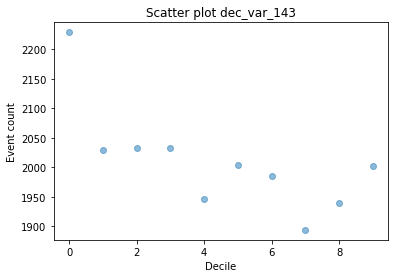

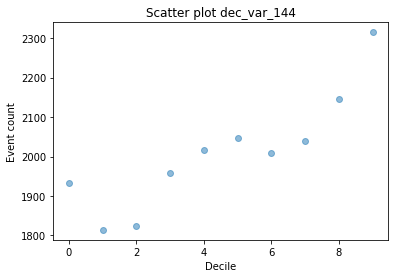

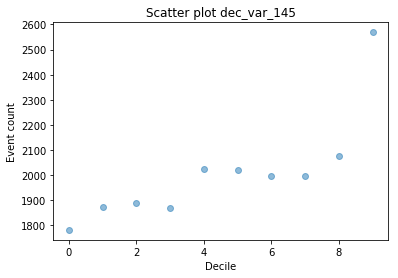

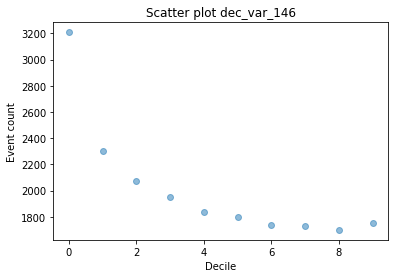

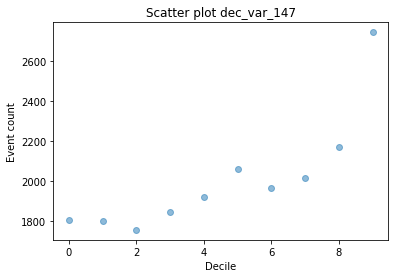

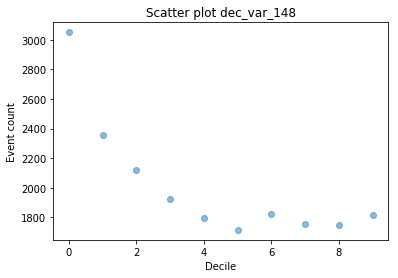

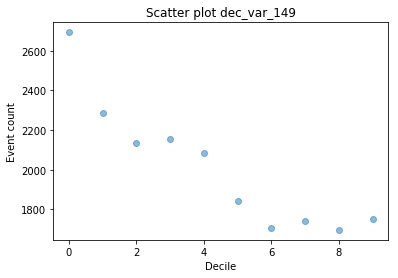

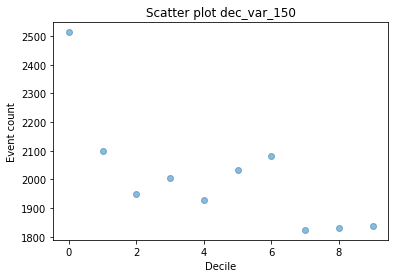

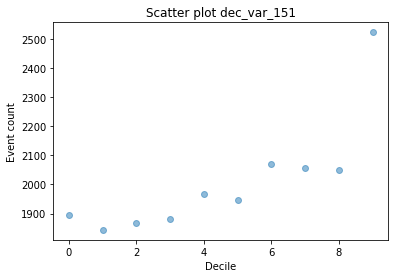

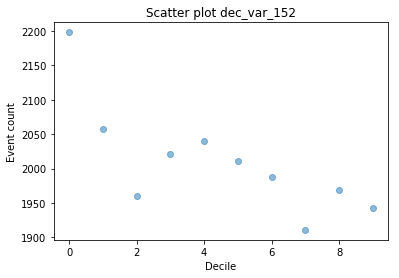

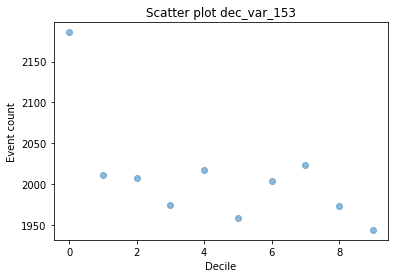

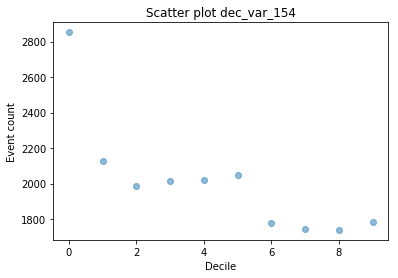

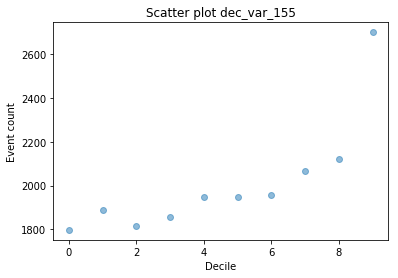

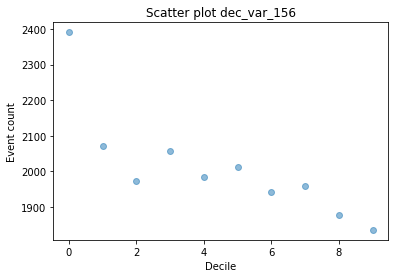

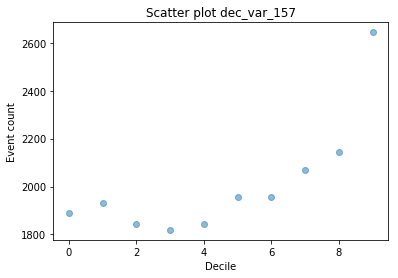

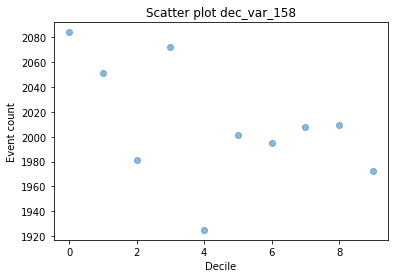

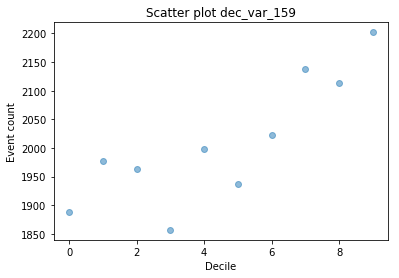

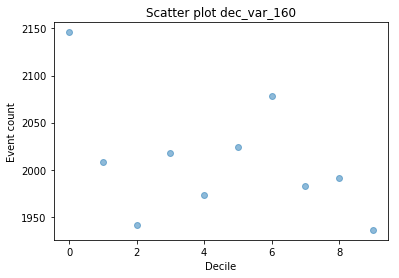

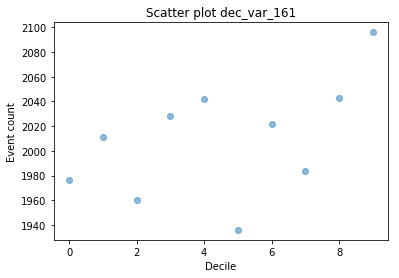

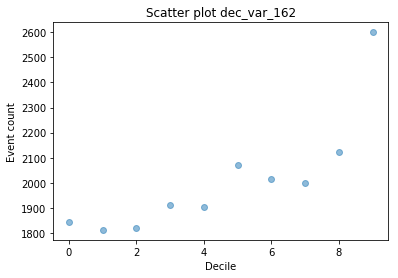

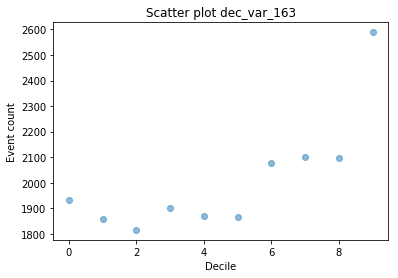

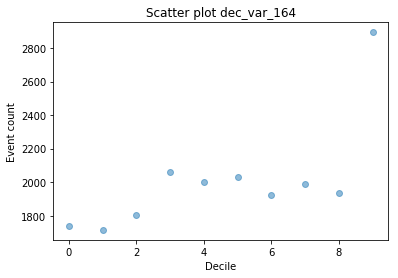

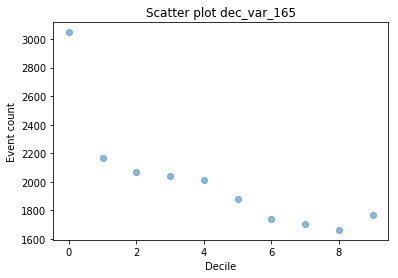

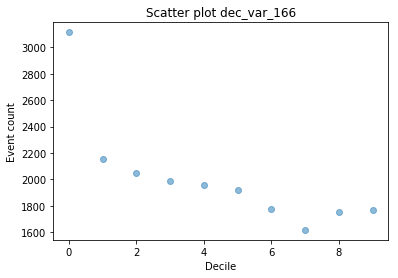

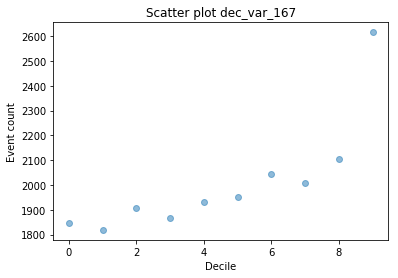

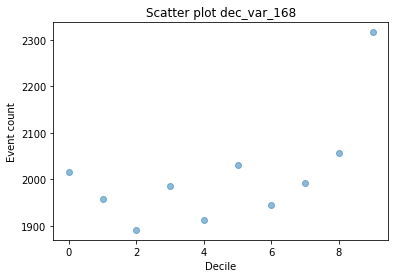

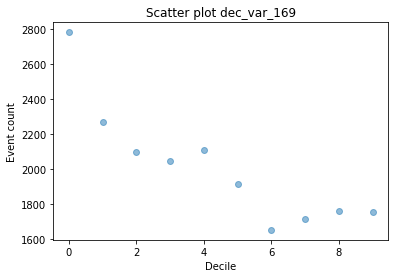

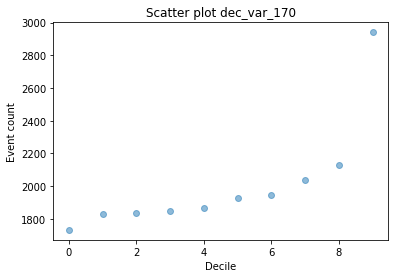

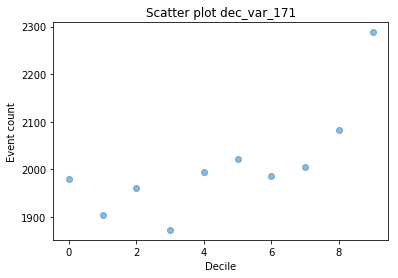

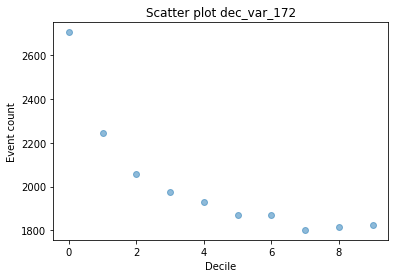

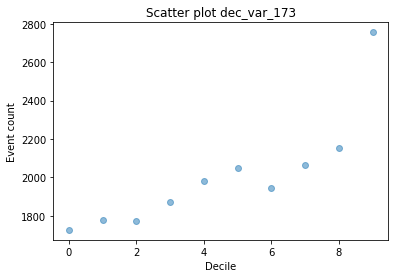

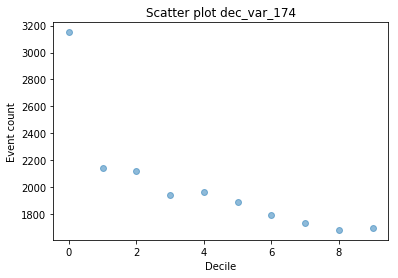

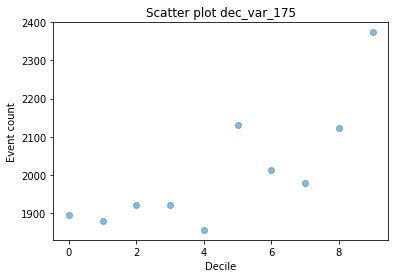

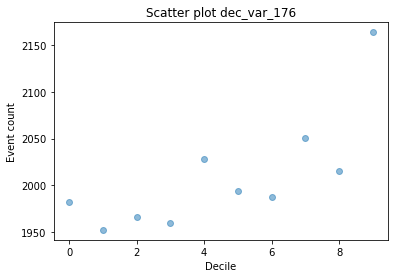

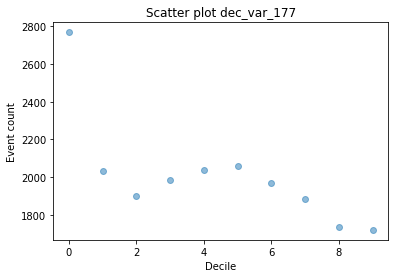

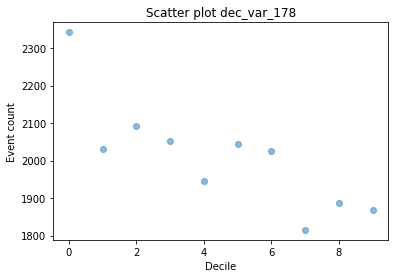

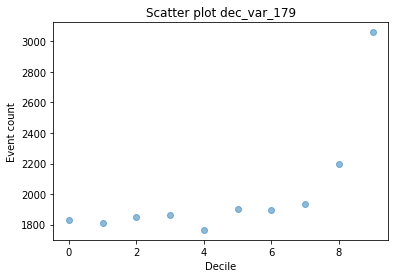

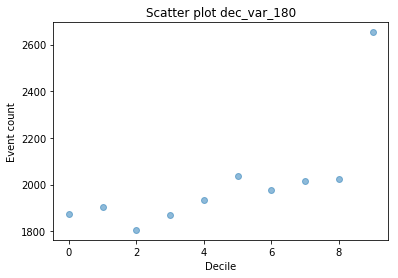

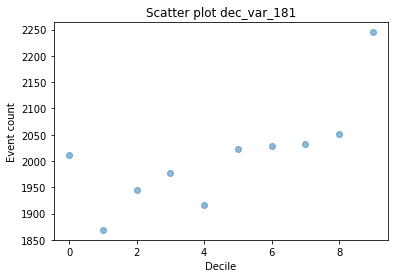

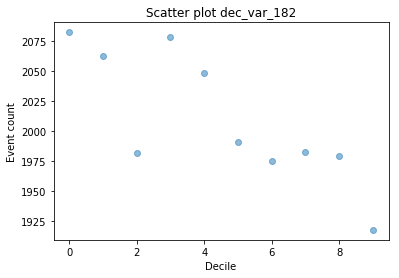

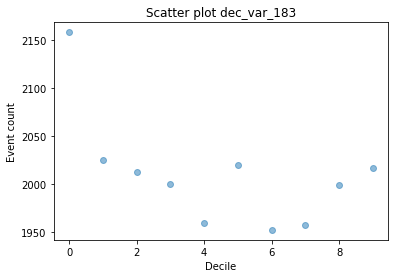

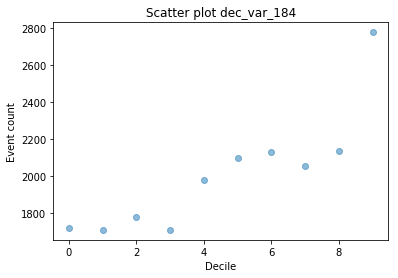

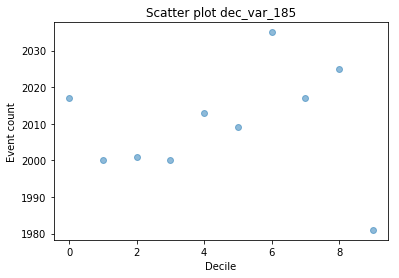

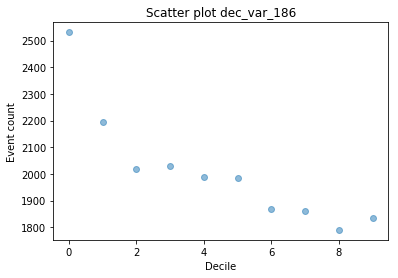

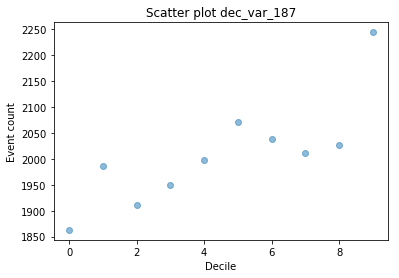

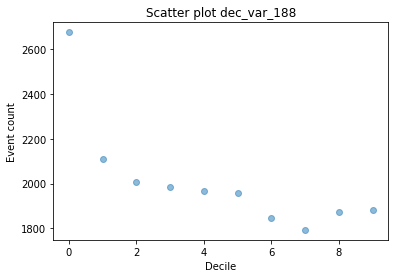

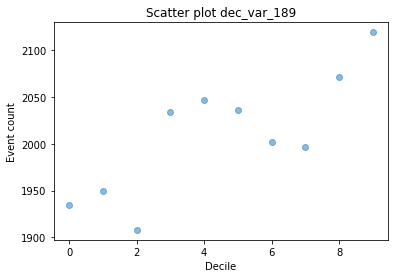

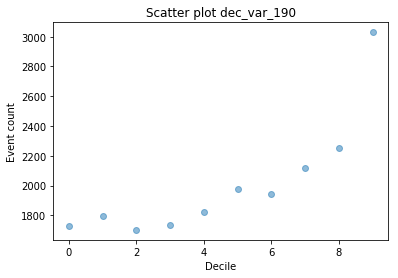

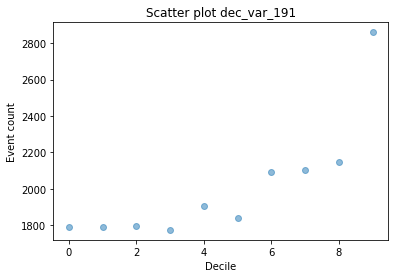

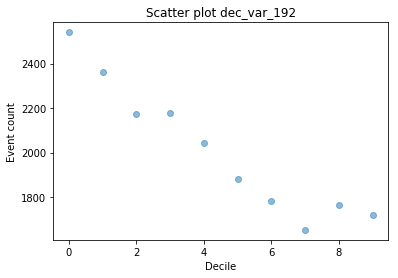

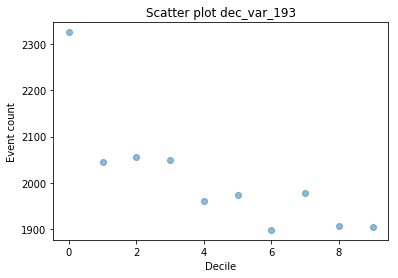

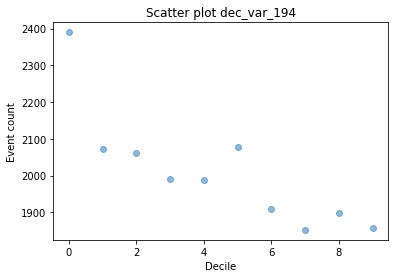

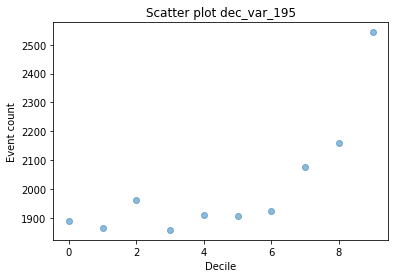

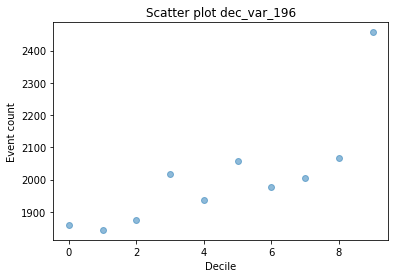

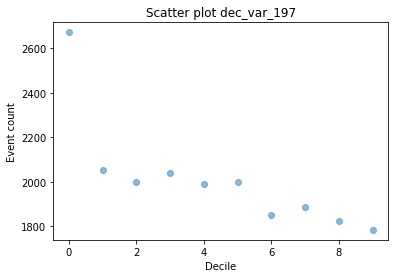

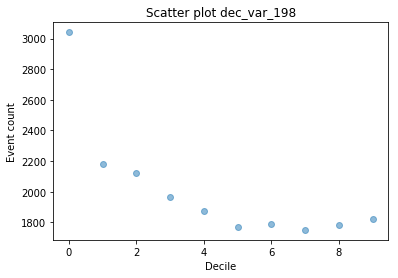

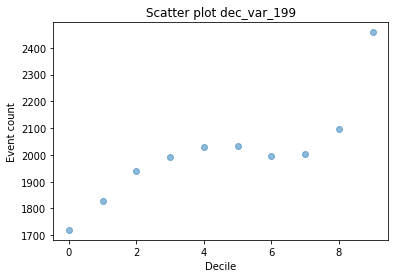

In [32]:
df_decile_0 = df_raw[['target']]
for i in vars:
    aux_var = 'dec_' + i
    df_decile_0[aux_var] = pd.qcut(df_raw[i], 10,labels=False)

    df_bivar = df_decile_0[[aux_var,'target']][df_decile_0.target == 1].groupby([aux_var]).sum()

    df_bivar.reset_index(drop=False, inplace = True)
    df_bivar

    # Plot
    plt.scatter(df_bivar[aux_var], df_bivar.target, alpha=0.5)
    plt.title('Scatter plot ' + aux_var)
    plt.xlabel('Decile')
    plt.ylabel('Event count')
    plt.show()

In [44]:
df_raw['var_test'] = np.log10(df_raw.var_0)

In [45]:
df_raw[['var_0','var_test']]

var_0  var_test
0        8.9255  0.950633
1       11.5006  1.060720
2        8.6093  0.934968
3       11.0604  1.043771
4        9.8369  0.992858
5       11.4763  1.059802
6       11.8091  1.072217
7       13.5580  1.132196
8       16.1071  1.207017
9       12.5088  1.097216
10       5.0702  0.705025
11      12.7188  1.104446
12       8.7671  0.942856
13      16.3699  1.214046
14      13.8080  1.140131
15       3.9416  0.595673
16       5.0615  0.704279
17       8.4199  0.925307
18       4.8750  0.687975
19       4.4090  0.644340
20      12.6700  1.102777
21       8.3918  0.923855
22      10.2031  1.008732
23      15.0029  1.176175
24       5.9240  0.772615
25       8.2703  0.917521
26      15.6567  1.194700
27      10.7166  1.030057
28       7.8010  0.892150
29       5.3301  0.726735
...         ...       ...
199970  15.5794  1.192551
199971  14.5745  1.163594
199972   7.4206  0.870439
199973   8.7758  0.943287
199974  16.2010  1.209542
199975   7.5238  0.876437
199976   7.9663  0.901257
199977   7.3884  0.868550
199978  12.2015  1.086413
199979  10.8208  1.034259
199980   7.9618  0.901011
199981  12.8140  1.107685
199982  11.8224  1.072706
199983  15.3063  1.184870
199984  11.3184  1.053785
199985   9.0249  0.955442
199986  12.0298  1.080258
199987   8.0438  0.905461
199988  10.8657  1.036058
199989  11.7554  1.070237
199990  14.1475  1.150680
199991   9.9909  0.999605
199992  12.2825  1.089287
199993  13.2152  1.121074
199994  12.3925  1.093159
199995  11.4880  1.060244
199996   4.9149  0.691515
199997  11.2232  1.050117
199998   9.7148  0.987434
199999  10.8762  1.036477

[200000 rows x 2 columns]

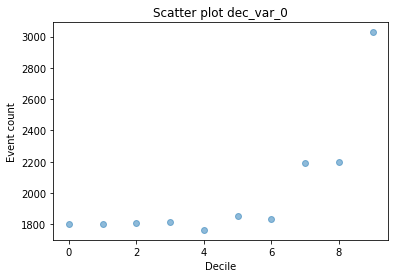

In [42]:
df_decile_0 = df_raw[['target']]
i = 'var_0'
aux_var = 'dec_' + i
df_decile_0[aux_var] = pd.qcut(df_raw[i], 10,labels=False)

df_bivar = df_decile_0[[aux_var,'target']][df_decile_0.target == 1].groupby([aux_var]).sum()

df_bivar.reset_index(drop=False, inplace = True)
df_bivar

# Plot
plt.scatter(df_bivar[aux_var], df_bivar.target, alpha=0.5)
plt.title('Scatter plot ' + aux_var)
plt.xlabel('Decile')
plt.ylabel('Event count')
plt.show()

In [49]:
df_decile_0 = df_raw[['target']]
i = 'var_0'
aux_var = 'dec_' + i
df_decile_0[aux_var] = pd.qcut(df_raw[i], 10,labels=False)
df_decile_0[i] = df_raw[i]

In [ ]:
df_bivar = df_decile_0[[aux_var,i]].groupby([aux_var]).mean()

In [50]:
df_bivar = df_decile_0[[aux_var,i]].groupby([aux_var]).mean()

In [51]:
df_bivar

var_0
dec_var_0           
0           5.745121
1           7.463466
2           8.450627
3           9.305348
4          10.117593
5          10.946542
6          11.826653
7          12.762013
8          13.883590
9          16.298622

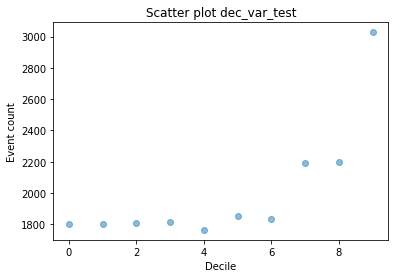

In [43]:
df_decile_0 = df_raw[['target']]
i = 'var_test'
aux_var = 'dec_' + i
df_decile_0[aux_var] = pd.qcut(df_raw[i], 10,labels=False)
df_decile_0[i] = df_raw[i]

df_bivar = df_decile_0[[aux_var,i]].groupby([aux_var]).mean()

df_bivar.reset_index(drop=False, inplace = True)
df_bivar

# Plot
plt.scatter(df_bivar[aux_var], df_bivar[i], alpha=0.5)
plt.title('Scatter plot ' + aux_var)
plt.xlabel('Decile')
plt.ylabel('Event count')
plt.show()

## Dividindo o Dataset em treino e teste

[Índice](#Índice)

In [ ]:
vars_rest = []
X_rest = df_raw[vars_rest]
y_rest = df_raw[['COMUNICADOS']]

X_rest_train, X_rest_test, y_rest_train, y_rest_test = train_test_split(X_rest, # Variáveis Explicativas
                                                                        y_rest,  # Variável Resposta
                                                                        test_size = 0.2, # Proporção entre treino e teste
                                                                        random_state = 0, # a 'semente' inicial garante a reprodutibilidade dos resultados
                                                                        stratify = y_rest.COMUNICADOS) # Garantia de que a proporção do evento se mantem no treino e no teste


LR_rest = LogisticRegression(penalty = 'l1',
                           max_iter=100,
                           C=1,
                           class_weight = 'balanced')

LR_rest.fit(X_rest_train,y_rest_train)
y_pred = LR_rest.predict(X_rest_test)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_raw.loc[:,df_raw.columns != 'target'], # Variáveis Explicativas
                                                    df_raw.target,  # Variável Resposta
                                                    test_size = 0.2, # Proporção entre treino e teste
                                                    random_state = 0, # a 'semente' inicial garante a reprodutibilidade dos resultados
                                                    stratify = df_raw.target) # Garantia de que a proporção do evento se mantem no treino e no teste

df_dev = pd.concat([X_train.reset_index(drop = True),y_train.reset_index(drop = True)],axis = 1)

print( '***** Percentual de evento na base de treino *****')
print (y_train.value_counts(normalize = True))
print( '***** Percentual de evento na base de teste  *****')
print (y_test.value_counts(normalize = True))

***** Percentual de evento na base de treino *****
0    0.899513
1    0.100487
Name: target, dtype: float64
***** Percentual de evento na base de teste  *****
0    0.8995
1    0.1005
Name: target, dtype: float64


# Benchmark

### Regressão Logística

[Índice](#Índice)


[Modelos](#Modelos)

In [17]:
df_result_metrics = pd.DataFrame() # DataFrame para armazenar todos os resultados obtidos

LR_l1 = LogisticRegression(penalty = 'l1',
                        max_iter=100,
                        C=1,
                        class_weight = 'balanced')

In [ ]:
SGD = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)


### Modelo com todas as variáveis, sem modificações no dataset

[Índice](#Índice)

In [ ]:
t1 = time.clock()
LR_l1.fit(X_train[vars],y_train)
y_pred = LR_l1.predict(X_test[vars])
t2 = time.clock()

classif_report = metrics.classification_report(y_test,y_pred) 
ROC_AUC = metrics.roc_auc_score(y_test,y_pred)
f1score = metrics.f1_score(y_test,y_pred)   
logloss = metrics.log_loss(y_test,y_pred)    
accuracy = metrics.accuracy_score(y_test,y_pred)   
precision = metrics.precision_score(y_test,y_pred)    
recall = metrics.recall_score(y_test,y_pred) 
scores = cross_val_score(LR_l1, X_train[vars],y_train, cv=5, scoring = 'roc_auc')
confusion_matrix(y_test,y_pred)
run_time = t2-t1


In [ ]:
df_result_metric_aux = pd.DataFrame({'Model': ['Logistic_Full_all_vars'],
                                     'ROC_AUC_OOS': [ROC_AUC],
                                     'f1-score':[f1score],
                                     'Log_loss': [logloss],
                                     'prec.':[precision],
                                     'recall':[recall],
                                     'ROC_AUC_CV_mean': [scores.mean()],
                                     'ROC_AUC_CV_sd': [scores.std()],
                                     'run time': [run_time]})

df_result_metrics = df_result_metrics.append(df_result_metric_aux)
df_result_metrics['Model'
                  ,'ROC_AUC_OOS'
                  ,'ROC_AUC_CV_mean']

# Organização dos datasets para utilização em todo o notebook


* Seleção de amostra ('sampling') - df_samp
* Balanceamento do evento na base ('Resampling') - df_resamp
* Normalização das variáveis

[Índice](#Índice)


# Sampling Dataset

 * Amostra de 20% do dataset original - df_samp

[Índice](#Índice)

In [ ]:
df_sampled = df_raw.sample(frac = 0.2, # Percentual selecionado aleatoriamente para desenvolvimento dos modelos
                           random_state = 0)

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(df_sampled.loc[:,df_sampled.columns != 'target'], # Variáveis Explicativas
                                                                                    df_sampled.target,  # Variável Resposta
                                                                                    test_size = 0.2, # Proporção entre treino e teste
                                                                                    random_state = 0, # a 'semente' inicial garante a reprodutibilidade dos resultados
                                                                                    stratify = df_sampled.target) # Garantia de que a proporção do evento se mantem no treino e no teste



print('Dimensões das variáveis explicativas na base de treino')
print(X_train_sampled.shape)
print()

print('Percentual de eventos na base de treino') # Garantindo a manutenção da taxa de evento nos datasets
print(y_train_sampled.value_counts(normalize = True))
print()

print('Dimensões das variáveis explicativas na base de teste')
print(X_test_sampled.shape)
print()

print('Percentual de eventos na base de teste') # Garantindo a manutenção da taxa de evento nos datasets
print(y_test_sampled.value_counts(normalize = True))
print()

## Distribuição das variáveis em relação ao evento

[Índice](#Índice)

In [ ]:
for i in vars:
    Var_AUX = i
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot( x=df_sampled['target'], y=df_sampled[i] )
#   plt.xlabel(Var_AUX)
#   plt.xticks(rotation=60)
    plt.title(Var_AUX)
    plt.ylabel('(u.a.)')

    del Var_AUX

In [ ]:
for i in vars:
    var_AUX = i
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.distplot(df_sampled[var_AUX][df_sampled.target == 0], 
                 hist = False,
                 kde = True, 
                 kde_kws = {'shade':True,
                            'linewidth':3})
    sns.distplot(df_sampled[var_AUX][df_sampled.target == 1], 
             hist = False,
             kde = True, 
             kde_kws = {'shade':True,
                        'linewidth':3})
#   plt.xlabel(Var_AUX)
#   plt.xticks(rotation=60)
    plt.title(var_AUX)
#    plt.ylabel('(u.a.)')

    del var_AUX

## Resampling

[Índice](#Índice)

In [ ]:
df_noEvent = df_sampled[df_sampled.target == 0]
df_Event = df_sampled[df_sampled.target == 1]

df_noEvent_resamp = df_noEvent.sample(n = (df_Event.shape[0]), #Seleção de amostra aleatória da população "não evento"
                                      random_state = 0)

df_resamp = pd.concat([df_noEvent_resamp.reset_index(drop=True), df_Event.reset_index(drop=True)],
                       axis = 0) # Combinação das populações "evento" e "não evento"

In [ ]:
print("Dimensões da população 'não-evento'")
print(df_noEvent_resamp.shape)
print()
print("Dimensões da população 'evento'")
print(df_Event.shape)
print()
print('Percentual de eventos no dataset criado: ')
print(df_resamp.target.value_counts(normalize = True))

In [ ]:
X_train_resamp, X_test_resamp, y_train_resamp, y_test_resamp = train_test_split(df_resamp.loc[:,df_resamp.columns != 'target'], # Variáveis Explicativas
                                                                                df_resamp.target,  # Variável Resposta
                                                                                test_size = 0.2, # Proporção entre treino e teste
                                                                                random_state = 0, # a 'semente' inicial garante a reprodutibilidade dos resultados
                                                                                stratify = df_resamp.target) # Garantia de que a proporção do evento se mantem no treino e no teste


### Normalização das Variáveis 

* Realizada com a função 'StandardScaler'

[Índice](#Índice)

In [ ]:
# Normalizando a amostra de treino do Dataset 
scaler = StandardScaler() #Normalização das variáveis levando em conta a distribuição (e não apenas min e max)
X_train_norm = scaler.fit_transform(X_train_sampled[vars])
X_train_norm = pd.DataFrame(data = X_train_norm, columns = vars)
print(X_train_norm.shape)
X_train_norm.head()

In [ ]:
# Normalizando a amostra de teste do Dataset 

X_test_norm = scaler.transform(X_test_sampled[vars])
X_test_norm = pd.DataFrame(data = X_test_norm, columns = vars)
print(X_test_norm.shape)
X_test_norm.head()

In [ ]:
# Normalizando a amostra balanceada de treino do Dataset 

X_train_norm_resamp = scaler.transform(X_train_resamp[vars])
X_train_norm_resamp = pd.DataFrame(data = X_train_norm_resamp, columns = vars)
print(X_train_norm_resamp.shape)
X_train_norm_resamp.head()

In [ ]:
# Normalizando a amostra balanceada de teste do Dataset 

X_test_norm_resamp = scaler.transform(X_test_resamp[vars])
X_test_norm_resamp = pd.DataFrame(data = X_test_norm_resamp, columns = vars)
print(X_test_norm_resamp.shape)
X_test_norm_resamp.head()

# Modelo

[Índice](#Índice)

## Regressão Logística

In [ ]:
# Modelo padrão, sem nenhuma alteração nos parâmetros, a não ser pela "class_weight"
# Este parâmetro leva em conta o desbalanceamento do evento, atribuindo 'cost functions' diferentes e proporcionais.

# Mesmo modelo utilizado na etapa de 'Benchmark'
LR_l1 = LogisticRegression(penalty = 'l1', # Tipo de regularização
                        max_iter=100,
                        C=1,
                        class_weight = 'balanced')

## Modelo com dataset balanceado - df_sampled

### Treinando o mesmo modelo LR_l1 com as mesmas características, mas com uma base menor (df_sampled)

In [ ]:
LR_l1.fit(X_train_norm[vars],y_train_sampled)
y_pred_sampled = LR_l1.predict(X_test_norm[vars])

classif_report = metrics.classification_report(y_test_sampled,y_pred_sampled) 
ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_sampled)
f1score = metrics.f1_score(y_test_sampled,y_pred_sampled)   
logloss = metrics.log_loss(y_test_sampled,y_pred_sampled)    
accuracy = metrics.accuracy_score(y_test_sampled,y_pred_sampled)   
precision = metrics.precision_score(y_test_sampled,y_pred_sampled)    
recall = metrics.recall_score(y_test_sampled,y_pred_sampled) 
scores = cross_val_score(LR_l1, X_train_norm[vars],y_train_sampled, cv=5, scoring = 'roc_auc')
confusion_matrix(y_test_sampled,y_pred_sampled)

In [ ]:
df_result_metric_aux2 = pd.DataFrame({'Model': ['Logistic_Samp_all_vars'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': [scores.mean()],
                                      'ROC_AUC_CV_sd': [scores.std()]})

df_result_metrics = df_result_metrics.append(df_result_metric_aux2)
df_result_metrics

## Modelo com dataset balanceado - df_resamp

#### Modelo treinado com dataset balanceado e testado na base com as proporções reais

### Teste do modelo no dataset balanceado

In [ ]:
LR_l1.fit(X_train_norm_resamp[vars],y_train_resamp)
y_pred_resamp = LR_l1.predict(X_test_norm_resamp[vars])
classif_report = metrics.classification_report(y_test_resamp,y_pred_resamp) 
ROC_AUC = metrics.roc_auc_score(y_test_resamp,y_pred_resamp)
f1score = metrics.f1_score(y_test_resamp,y_pred_resamp)   
logloss = metrics.log_loss(y_test_resamp,y_pred_resamp)    
accuracy = metrics.accuracy_score(y_test_resamp,y_pred_resamp)   
precision = metrics.precision_score(y_test_resamp,y_pred_resamp)    
recall = metrics.recall_score(y_test_resamp,y_pred_resamp) 
scores = cross_val_score(LR_l1, X_train_norm_resamp[vars],y_train_resamp, cv=5, scoring = 'roc_auc')
confusion_matrix(y_test_resamp,y_pred_resamp)

In [ ]:
df_result_metric_aux3 = pd.DataFrame({'Model': ['Logistic_Resamp_all_vars'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': [scores.mean()],
                                      'ROC_AUC_CV_sd': [scores.std()]})

df_result_metrics = df_result_metrics.append(df_result_metric_aux3)
df_result_metrics

### Teste do modelo no dataset com a proporção original

In [ ]:
LR_l1.fit(X_train_norm_resamp[vars],y_train_resamp)
y_pred_resamp_test = LR_l1.predict(X_test_norm[vars])
classif_report = metrics.classification_report(y_test_sampled,y_pred_resamp_test) 
ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_resamp_test)
f1score = metrics.f1_score(y_test_sampled,y_pred_resamp_test)   
logloss = metrics.log_loss(y_test_sampled,y_pred_resamp_test)    
accuracy = metrics.accuracy_score(y_test_sampled,y_pred_resamp_test)   
precision = metrics.precision_score(y_test_sampled,y_pred_resamp_test)    
recall = metrics.recall_score(y_test_sampled,y_pred_resamp_test) 
scores = cross_val_score(LR_l1, X_train_norm_resamp[vars],y_train_resamp, cv=5, scoring = 'roc_auc')
confusion_matrix(y_test_sampled,y_pred_resamp_test)

In [ ]:
df_result_metric_aux4 = pd.DataFrame({'Model': ['Logistic_Resamp_all_vars_train_imbal'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': [scores.mean()],
                                      'ROC_AUC_CV_sd': [scores.std()]})

df_result_metrics = df_result_metrics.append(df_result_metric_aux4)
df_result_metrics

## Teste de importância das variáveis

* O objetivo desta etapa é quantificar a contribuição de cada variável do dataset para o modelo gerado.

[Índice](#Índice)

In [ ]:
def teste_variaveis(Var, X_train, y_train, X_test, y_test):

    LR_l1.fit(X_train[[Var]],y_train)
    y_pred = LR_l1.predict(X_test[[Var]])
    classif_report = metrics.classification_report(y_test,y_pred) 
    ROC_AUC = metrics.roc_auc_score(y_test,y_pred)
    f1score = metrics.f1_score(y_test,y_pred)   
    logloss = metrics.log_loss(y_test,y_pred)    
    accuracy = metrics.accuracy_score(y_test,y_pred)   
    precision = metrics.precision_score(y_test,y_pred)    
    recall = metrics.recall_score(y_test,y_pred)    

    df_parametros = pd.DataFrame({'Var': [Var],
                                  'ROC_AUC_OOS': [ROC_AUC],
                                  'f1-score':[f1score],
                                  'Log_loss': [logloss],
                                  'prec.':[precision],
                                  'recall':[recall]})
    return df_parametros

In [ ]:
# Esta etapa treina o modelo de forma independente com cada uma das variáveis e armazena as métricas de interesse
df_var_importancia = pd.DataFrame()
for i in vars:
    df_var_imp_AUX = teste_variaveis(i,X_train_norm_resamp,y_train_resamp,X_test_norm,y_test_sampled)
    df_var_importancia = df_var_importancia.append(df_var_imp_AUX) 

In [ ]:
# Esta etapa ordena as variáveis de acordo com sua contribuição para o modelo gerado (neste caso: 'ROC_AUC')

df_var_importancia.sort_values('ROC_AUC_OOS',ascending = False, inplace = True)
df_var_importancia.loc[:,['Var','ROC_AUC_OOS','Log_loss','f1-score','prec.','recall']]
df_var_importancia.reset_index(drop=True)

## Correlação das variáveis

* Esta etapa identifica as variáveis correlacionadas entre si, isto é, que trazem a mesma informação para o modelo
* Aqui as variáveis correlacionadas são removidas do dataset, de acordo com o limiar escolhido, respeitando a ordenação de importância obtida na etapa anterior

[Índice](#Índice)

In [ ]:
vars_to_test = list(df_var_importancia.Var) #lista de variáveis, em ordem de importância
df_corr = df_sampled[vars_to_test].corr().abs() #correlação entre as variâveis explicativas do dataset

# Seleciona o 'triangulo' superior da matriz de correlação, acima da diagonal principal
upper_corr = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

# Seleciona as variáveis com correlação acima do limiar definido - 0.75 neste caso
to_drop_vars = [column for column in upper_corr.columns if any(upper_corr[column] >= 0.75)]

print(np.shape(to_drop_vars))

print(to_drop_vars)

In [ ]:
for i in to_drop_vars:
    vars_to_test.remove(i)
    print (i)

# print(vars_to_test)

# Neste caso, nenhuma variável foi removida do dataset (não existem variáveis altamente correlacionadas no Dataset).

# Função para inclusão das variáveis

* Esta função inclui variáveis, uma a uma, e re-treina o modelo, armazenando as métricas resultantes em uma dataset para análise posterior.
* Nesta etapa, é possível avaliar a real contribuição da inclusão de cada variável, respeitando a ordem de importância obtida anteriormente.

[Índice](#Índice)

In [ ]:
def inclui_var(X_train, X_test, y_train, y_test, lista_var):

    X_model_train = X_train[lista_var].reset_index(drop=True)
    X_model_test = X_test[lista_var].reset_index(drop=True)
    df_var_consolid = pd.DataFrame()
    LR = LogisticRegression(penalty = 'l1', # Tipo de regularização
                            max_iter=100,
                            C=1,
                            class_weight = 'balanced')
    for i in range(1,len(lista_var),1):
        
        print('rodando '+ lista_var[i-1])
        df_var = pd.DataFrame()
        
        LR.fit(X_model_train.iloc[:,:i],y_train)
        y_pred = LR.predict(X_model_test.iloc[:,:i])
        
        classif_report = metrics.classification_report(y_test,y_pred) 
        ROC_AUC = metrics.roc_auc_score(y_test,y_pred)
        f1score = metrics.f1_score(y_test,y_pred)   
        logloss = metrics.log_loss(y_test,y_pred)    
        accuracy = metrics.accuracy_score(y_test,y_pred)   
        precision = metrics.precision_score(y_test,y_pred)    
        recall = metrics.recall_score(y_test,y_pred)    

        df_aux = pd.DataFrame({'Variável': lista_var[i-1],
                               'n_variaveis': [i],
                               'ROC_AUC_OOS': ROC_AUC,
                               'f1-score': f1score,
                               'Log_loss': logloss,
                               'precision':precision,
                               'recall': recall})
        
        df_var_consolid = pd.concat([df_var_consolid,df_aux],axis = 0)
        
    return df_var_consolid  

In [ ]:
# DataFrame em branco para armazenar as métricas obtidas pela inclusão de cada variável
df_var_consolid = pd.DataFrame()

df_teste_vars = inclui_var(X_train_norm_resamp, X_test_norm, y_train_resamp, y_test_sampled, vars_to_test)

In [ ]:
df_teste_vars

# Visualização do resultado da inclusão das variáveis

* Visualização da variação das métricas em função da inclusão das variáveis e comparação com a "importância das variáveis" obtidas no modelo treinado com o dataset balanceado (df_resamp) que mostrou melhor performance

[Índice](#Índice)

In [ ]:
# Importância das variáveis obtida no treino do modelo com todas as variáveis

# Rodamos o modelo aqui mais uma vez para garantir os coeficientes de LR_l1
LR_l1.fit(X_train_norm_resamp[vars],y_train_resamp)
y_pred_resamp_test = LR_l1.predict(X_test_norm[vars])

Import_vars = pd.DataFrame({'Var':vars,
                            'Importancia': pd.DataFrame(np.transpose(LR_l1.coef_))[0].abs()})

#Ordenação das variáveis pela importância
Import_vars.sort_values('Importancia',ascending = False, inplace = True)
Import_vars.reset_index(drop=True,inplace = True)

In [ ]:
plt.subplots(2,2,figsize=(14,10))

# ROC_AUC
plt.subplot(2,2,1)
plt.plot(df_teste_vars['n_variaveis'],df_teste_vars['ROC_AUC_OOS'])
#plt.xlabel()
plt.title('ROC_AUC vs N_vars').figsize=(6, 4)
#plt.ylabel()
plt.grid(which='both',axis = 'both')

# f1 Score
plt.subplot(2,2,2)
plt.plot(df_teste_vars['n_variaveis'],df_teste_vars['f1-score'])
#plt.xlabel()
plt.title('f1-score vs N_vars')
#plt.ylabel()
plt.grid(which='both',axis = 'both')

# Log Loss
plt.subplot(2,2,3)
plt.plot(df_teste_vars['n_variaveis'],df_teste_vars['Log_loss'])
plt.xlabel('Num Variáveis')
plt.title('Log_loss vs N_vars')
#plt.ylabel()
plt.grid(which='both',axis = 'both')

# Importância das variáveis
plt.subplot(2,2,4)
plt.plot(Import_vars.index,Import_vars['Importancia'])
plt.xlabel('Num Variáveis')
plt.title('Feature_Importance')
#plt.ylabel()
plt.grid(which='both',axis = 'both')


plt.show()

In [ ]:
df_teste_vars[df_teste_vars.ROC_AUC_OOS == df_teste_vars.ROC_AUC_OOS.max()]

##### Principais resultados desta etapa

* Pelo gráfico da variação da curva ROC_AUC, é possível observar que podemos obter métricas semelhantes, utilizando pouco mais da metade das variáveis do dataset (aprox. 110 variáveis), ou ainda o valor máximo, de 0.78, com 175 variáveis.
* Esta mesma informação não pode ser obtida apensa pela métrica 'feature_importances_', como mostra a figura na parte inferior direita.

[Índice](#Índice)

## Considerando que o obtivo do teste é obter a maior ROC_AUC, escolhemos o ponto de maior valor da métrica (n_vars = 175)

In [ ]:
Optimized_vars = list(df_var_importancia.loc[:155,'Var'])

# Modelo com o número de variáveis otimizado

[Índice](#Índice)

In [ ]:
LR_l1.fit(X_train_norm_resamp[Optimized_vars],y_train_resamp)
y_pred_resamp_test = LR_l1.predict(X_test_norm[Optimized_vars])

classif_report = metrics.classification_report(y_test_sampled,y_pred_resamp_test) 
ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_resamp_test)
f1score = metrics.f1_score(y_test_sampled,y_pred_resamp_test)   
logloss = metrics.log_loss(y_test_sampled,y_pred_resamp_test)    
accuracy = metrics.accuracy_score(y_test_sampled,y_pred_resamp_test)   
precision = metrics.precision_score(y_test_sampled,y_pred_resamp_test)    
recall = metrics.recall_score(y_test_sampled,y_pred_resamp_test) 
scores = cross_val_score(LR_l1, X_train_resamp[Optimized_vars],y_train_resamp, cv=5, scoring = 'roc_auc')

confusion_matrix(y_test_sampled,y_pred_resamp_test)

In [ ]:
df_result_metric_aux5 = pd.DataFrame({'Model': ['Logistic_Resamp_opt_vars_train_imbal'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': [scores.mean()],
                                      'ROC_AUC_CV_sd': [scores.std()]})

df_result_metrics = df_result_metrics.append(df_result_metric_aux5)
df_result_metrics

# Otimização dos parâmetros do modelo de reg. logística

* Nesta etapa, avaliamos qual a melhor combinação de parâmetros (hiperparâmetros) para este modelo e este problema específico
* Esta etapa é similar à função 'GridSearchCV' do scikit learn. Porém, aqui é possível avaliar a variação de todas as métricas de interesse a cada iteração.

[Índice](#Índice)

In [ ]:
# Loop para avaliação de todas as combinações entre os parâmetros de interesse - Similar ao GridSearchCV

reg = ['l1','l2']
max_iterations = [10,50,100,300]
peso_reg = [1,3,5,7,10]
df_aux_consolid = pd.DataFrame()

for i in reg:
    for j in max_iterations:
        for k in peso_reg:
            LR_test = LogisticRegression(penalty = i,
                                         max_iter = j,
                                         C = k,
                                         class_weight = 'balanced')
            
            LR_test.fit(X_train_norm_resamp[Optimized_vars],y_train_resamp)
            y_pred_test = LR_test.predict(X_test_norm[Optimized_vars])
            
            classif_report = metrics.classification_report(y_test_sampled,y_pred_test) 
            ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_test)
            f1score = metrics.f1_score(y_test_sampled,y_pred_test)   
            logloss = metrics.log_loss(y_test_sampled,y_pred_test)    
            accuracy = metrics.accuracy_score(y_test_sampled,y_pred_test)   
            precision = metrics.precision_score(y_test_sampled,y_pred_test)    
            recall = metrics.recall_score(y_test_sampled,y_pred_test)
            score_test = cross_val_score(LR_test, 
                                         X_train_resamp[Optimized_vars],
                                         y_train_resamp, 
                                         cv=5, 
                                         scoring = 'roc_auc')
            
            df_aux = pd.DataFrame({'Reg': [i],
                                   'Max_Iter': [j],
                                   'Peso_Reg': [k],
                                   'ROC_AUC_OOS': [ROC_AUC],
                                   'f1-score':[f1score],
                                   'Log_loss': [logloss],
                                   'prec.':[precision],
                                   'recall':[recall],
                                   'ROC_AUC_CV_mean': [score_test.mean()],
                                   'ROC_AUC_CV_sd': [score_test.std()]})
            
            df_aux_consolid = pd.concat([df_aux_consolid,df_aux],axis = 0)

In [ ]:
df_aux_consolid.sort_values('ROC_AUC_OOS', ascending = False)

In [ ]:
df_aux_consolid.sort_values('ROC_AUC_CV_mean', ascending = False)

## Resultados do processo de otimização

* Pelos resultados obtidos acima, chegamos na versão otimizada do modelo com a melhor combinação de variáveis e de parâmetros


* Parâmetros:
    - Max_iter = 10
    - penalty = L2
    - C = 1
    
    
* Estes parâmetros retornaram um valor ROC_AUC com validação cruzada(CV) um pouco abaixo (na terceira casa decimal), mas todos os outros parâmetros foram superiores, além de ser um modelo de menor complexidade

* As variáveis finais estão armazenadas em 'Optimized_vars'

[Índice](#Índice)

In [ ]:
LR_final = LogisticRegression(penalty = 'l1',
                              max_iter = 10,
                              C = 1,
                              class_weight = 'balanced')

In [ ]:
LR_final.fit(X_train_resamp[Optimized_vars],y_train_resamp)
y_pred_final = LR_final.predict(X_test_norm[Optimized_vars])

classif_report = metrics.classification_report(y_test_sampled,y_pred_final) 
ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_final)
f1score = metrics.f1_score(y_test_sampled,y_pred_final)   
logloss = metrics.log_loss(y_test_sampled,y_pred_final)    
accuracy = metrics.accuracy_score(y_test_sampled,y_pred_final)   
precision = metrics.precision_score(y_test_sampled,y_pred_final)    
recall = metrics.recall_score(y_test_sampled,y_pred_final) 
scores = cross_val_score(LR_final, X_train_resamp[Optimized_vars],y_train_resamp, cv=5, scoring = 'roc_auc')

confusion_matrix(y_test_sampled,y_pred_final)

In [ ]:
df_result_metric_aux6 = pd.DataFrame({'Model': ['Logistic_Resamp_opt_final'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': [scores.mean()],
                                      'ROC_AUC_CV_sd': [scores.std()]})

df_result_metrics = df_result_metrics.append(df_result_metric_aux6)
df_result_metrics

# Visualização do Threshold do Evento

[Índice](Índice)

In [ ]:
df_visual = pd.DataFrame({'prob':(LR_final.predict_proba(X_test_sampled[Optimized_vars])[:,1]),
                          'evento':(y_test_sampled)})

In [ ]:
df_visual_no_evento = df_visual[df_visual.evento == 0]
df_visual_evento = df_visual[df_visual.evento == 1]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df_visual_evento['prob'],
             hist = True,
             kde = True, 
             kde_kws = {'shade':True,
                        'linewidth':3})
sns.distplot(df_visual_no_evento['prob'],
             hist = True,
             kde = True, 
             kde_kws = {'shade':True,
                        'linewidth':3})
#   plt.xlabel(Var_AUX)
#   plt.xticks(rotation=60)
#    plt.title(Var_AUX)
#    plt.ylabel('(u.a.)')


# XGBoost - Extreme Gradient Boosting

* Nesta etapa, utilizamos o mesmo processo realizado para o modelo de Reg. Logística, para avaliar as performance do XGBoost na resolução do problema 

* Aqui, no entanto, partimos do dataset já reduzido por amostragem aleatória

* Relembrando:
    - Dataset com 20% da amostra: X_train_norm, y_train_sampled, X_test_norm e y_test_sampled
    - Neste caso, ao contrário da regressão logística, o XGB não mostrou bons resultados com o balanceamento do dataset

[Índice](#Índice)

In [ ]:
xgbr = XGBClassifier(eta = 0.3,
                     gamma = 0,
                     max_depth = 3,
                     min_child_weight = 1,
                     reg_lambda = 1,
                     reg_alpha = 0,
                     tree_method = 'auto',
                     n_estimators = 100,
                     learn_rate = 0.1,
                     random_state = 0)

## Treinando o modelo com a amostra do dataset normalizada - df_norm

[Índice](#Índice)

In [ ]:
xgbr.fit(X_train_norm[vars],y_train_sampled)
y_pred_sampled = xgbr.predict(X_test_norm[vars])

In [ ]:
classif_report = metrics.classification_report(y_test_sampled,y_pred_sampled) 
ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_sampled)
f1score = metrics.f1_score(y_test_sampled,y_pred_sampled)   
logloss = metrics.log_loss(y_test_sampled,y_pred_sampled)    
accuracy = metrics.accuracy_score(y_test_sampled,y_pred_sampled)   
precision = metrics.precision_score(y_test_sampled,y_pred_sampled)    
recall = metrics.recall_score(y_test_sampled,y_pred_sampled) 
#scores = cross_val_score(xgbr, X_train_norm[vars],y_train_sampled, cv=4, scoring = 'roc_auc')

confusion_matrix(y_test_sampled,y_pred_sampled)

* O treino com todas as variáveis originais e com os parâmetros 'default'  do algoritmo não chegou a bons resultados, principalmente em relação à sensibilidade na identificação dos eventos (recall)

In [ ]:
df_result_metric_aux7 = pd.DataFrame({'Model': ['XGB_Samp_all_vars'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': ['N/A'],
                                      'ROC_AUC_CV_sd': ['N/A']})

df_result_metrics = df_result_metrics.append(df_result_metric_aux7)
df_result_metrics

## Treinando o modelo com dataset balanceado

* O próximo passo foi treinar o modelo com o dataset balanceado e comparar os resultados

In [ ]:
xgbr.fit(X_train_norm_resamp[vars],y_train_resamp)
y_pred_resamp = xgbr.predict(X_test_sampled[vars])

classif_report = metrics.classification_report(y_test_sampled,y_pred_resamp) 
ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_resamp)
f1score = metrics.f1_score(y_test_sampled,y_pred_resamp)   
logloss = metrics.log_loss(y_test_sampled,y_pred_resamp)    
accuracy = metrics.accuracy_score(y_test_sampled,y_pred_resamp)   
precision = metrics.precision_score(y_test_sampled,y_pred_resamp)    
recall = metrics.recall_score(y_test_sampled,y_pred_resamp) 
#scores = cross_val_score(xgbr, X_train_norm_resamp[vars],y_train_resamp, cv=4, scoring = 'roc_auc')

confusion_matrix(y_test_sampled,y_pred_resamp)

* A alteração na proporção dos eventos fez com que o algoritmo classificasse todos as observações como evento (target = 1)

In [ ]:
df_result_metric_aux8 = pd.DataFrame({'Model': ['XGB_Resamp_all_vars'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': ['N/A'],
                                      'ROC_AUC_CV_sd': ['N/A']})

df_result_metrics = df_result_metrics.append(df_result_metric_aux8)
df_result_metrics

### Alteração na estratégia de resolução do problema

* Neste caso, como o modelo não mostrou bons resultados pelo mesmo princípio, podemos inverter as etapas e trabalhar primeiro na otimização dos parâmetros do modelo

# Escolha dos melhores parâmetros para o modelo

[Índice](#Índice)

In [ ]:
# Loop para avaliação de todas as combinações entre os parâmetros de interesse - Similar ao GridSearchCV
df_aux_consolid = pd.DataFrame()

Gamma = [0,1,2]
Prof_Max = [3,4,5]
Reg_Lambda = [1,2]
Reg_Alpha = [0,1]
Estimadores = [1000]
Learning_Rate = [0.01,0.03,0.05,0.1]

for a in Gamma:
    for b in Prof_Max:
        for c in Reg_Lambda:
            for d in Reg_Alpha:
                for e in Estimadores:
                    for f in Learning_Rate:
                                                                
                        xgbr_test = XGBClassifier(eta = 0.3,
                                             gamma = a,
                                             max_depth = b,
                                             min_child_weight = 1,
                                             reg_lambda = c,
                                             reg_alpha = d,
                                             tree_method = 'auto',
                                             n_estimators = e,
                                             learn_rate = f,
                                             random_state = 0)

                        xgbr_test.fit(X_train_norm[vars],y_train_sampled)
                        y_pred_test = xgbr_test.predict(X_test_norm[vars])

                        classif_report = metrics.classification_report(y_test_sampled,y_pred_test) 
                        ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_test)
                        f1score = metrics.f1_score(y_test_sampled,y_pred_test)   
                        logloss = metrics.log_loss(y_test_sampled,y_pred_test)    
                        accuracy = metrics.accuracy_score(y_test_sampled,y_pred_test)   
                        precision = metrics.precision_score(y_test_sampled,y_pred_test)    
                        recall = metrics.recall_score(y_test_sampled,y_pred_test)
                        

                        df_aux = pd.DataFrame({'Gamma': [a],
                                               'Max_Depth': [b],
                                               'Lambda': [c],
                                               'Alpha': [d],
                                               'Estimators': [e],
                                               'Learn_Rate': [f],
                                               'ROC_AUC': [ROC_AUC],
                                               'f1-score':[f1score],
                                               'Log_loss': [logloss],
                                               'prec.':[precision],
                                               'recall':[recall]})

                        print(df_aux)

                        df_aux_consolid = pd.concat([df_aux_consolid,df_aux],axis = 0)

In [ ]:
df_aux_consolid

* Nesta etapa, podemos utilizar os melhores parâmetros, obtidos acima, e trabalhar na seleção das variáveis posteriormente.
* Como já sabemos do início que as variáveis não são correlacionadas entre si, como visto na etapa de [Correlação das Variáveis](#Correlação-das-variáveis), podemos ordenar as variáveis pelo parâmetro 'feature_importances_' do algoritmo e verificar como a inclusão das variáveis, nesta ordem, influencia na performance do modelo.

In [ ]:
df_aux_consolid.sort_values('ROC_AUC',ascending = False, inplace = True)
df_aux_consolid.reset_index(drop = True, inplace = True)
df_aux_consolid

In [ ]:
# Modelo com os parâmetros otimizados na etapa anterior
xgbr_final = XGBClassifier(gamma = 0,
                           max_depth = 3,
                           reg_lambda = 2,
                           reg_alpha = 2,
                           n_estimators = 1000,
                           learn_rate = 0.01,
                           random_state = 0)

xgbr_final.fit(X_train_norm[vars],y_train_sampled)
y_pred_test = xgbr_final.predict(X_test_norm[vars])

## Importância das variáveis - XGB

* Como o processo de inclusão das variáveis, realizado na etapa anterior é muito custoso para o XGB nesta janela temporal, aqui podemos selecionar as variáveis de acordo com sua importância na construção do modelo, indicada pelo parâmetro 'feature_importances_'

[Índice](#Índice)

In [ ]:
Import_vars_xgb = pd.DataFrame({'Var':vars,
                                'Importancia': xgbr_final.feature_importances_})

#Ordenação das variáveis pela importância
Import_vars_xgb.sort_values('Importancia',ascending = False, inplace = True)
Import_vars_xgb.reset_index(drop=True,inplace = True)

In [ ]:
Import_vars_xgb

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize = (15,40))

# Example data
var = Import_vars_xgb['Var']
y_pos = np.arange(len(var))
importance = Import_vars_xgb['Importancia']

ax.barh(y_pos, importance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('importance')
ax.set_ylabel('variaveis')
ax.set_title('var -- importance >> xg')

plt.show()

##### Principais resultados desta etapa

* Pelo gráfico da variação da curva ROC_AUC, é possível observar que podemos obter métricas semelhantes, utilizando pouco mais da metade das variáveis do dataset (aprox. 110 variáveis), ou ainda o valor máximo, de 0.78, com 175 variáveis.
* Esta mesma informação não pode ser obtida apensa pela métrica 'feature importances_', como mostra a figura na parte inferior direita.

[Índice](#Índice)

## Seleção das variáveis - XGB

* Aqui, selecionamso as variáveis definindo a inclusão das variáveis com coeficiente maior que 0.005
* Esta limiarização diminui o número de variáveis utilizadas no modelo que, em teoria, trazem pouca informação ao estudo, como podemos observar na manutenção da performance do modelo

[Índice](#Índice)

In [ ]:
Optimized_vars_xgbb = list(Import_vars_xgb['Var'][Import_vars_xgb.Importancia > 0.005])

In [ ]:
np.shape(Optimized_vars_xgbb)

## Resultados do processo de otimização - XGB

* Pelos resultados obtidos acima, chegamos na versão otimizada do modelo com a melhor combinação de variáveis e de parâmetros


* Parâmetros:
    - gamma: 0
    - max_depth: 3
    - reg_lambda: 2
    - reg_alpha: 2
    - n_estimators: 1000 
    - learn_rate: 0.01
    
    
* Nesta etapa, não foi feita a validação cruzada pela limitação de tempo

* As variáveis finais estão armazenadas em 'Optimized_vars'

[Índice](#Índice)

In [ ]:
xgbr_final.fit(X_train_norm[Optimized_vars_xgbb],y_train_sampled)
y_pred_final = xgbr_final.predict(X_test_norm[Optimized_vars_xgbb])

classif_report = metrics.classification_report(y_test_sampled,y_pred_final) 
ROC_AUC = metrics.roc_auc_score(y_test_sampled,y_pred_final)
f1score = metrics.f1_score(y_test_sampled,y_pred_final)   
logloss = metrics.log_loss(y_test_sampled,y_pred_final)    
accuracy = metrics.accuracy_score(y_test_sampled,y_pred_final)   
precision = metrics.precision_score(y_test_sampled,y_pred_final)    
recall = metrics.recall_score(y_test_sampled,y_pred_final) 
# scores = cross_val_score(LR_final, X_train_resamp[Optimized_vars],y_train_resamp, cv=5, scoring = 'roc_auc')

confusion_matrix(y_test_sampled,y_pred_final)

# Visualização do Threshold do Evento

[Índice](Índice)

In [ ]:
df_visual_xgb = pd.DataFrame({'prob':(xgbr_final.predict_proba(X_test_norm[Optimized_vars_xgbb])[:,1]),
                              'evento':(y_test_sampled)})
df_visual_xgb.prob.min()

In [ ]:
df_visual_xgb.prob.max()

In [ ]:
df_visual_xgb_no_evento = df_visual_xgb[df_visual_xgb.evento == 0]
df_visual_xgb_evento = df_visual_xgb[df_visual_xgb.evento == 1]

In [ ]:
df_visual_xgb_evento[df_visual_xgb_evento.prob > 0.5].count()

In [ ]:
df_visual_xgb_evento[df_visual_xgb_evento.prob <= 0.5].count()

In [ ]:
df_visual_xgb_evento[df_visual_xgb_evento.prob > 0.1].count()

In [ ]:
df_visual_xgb_evento[df_visual_xgb_evento.prob <= 0.1].count()

In [ ]:
df_visual_xgb_no_evento[df_visual_xgb_no_evento.prob > 0.5].count()

In [ ]:
df_visual_xgb_no_evento[df_visual_xgb_no_evento.prob <= 0.5].count()

In [ ]:
df_visual_xgb_no_evento[df_visual_xgb_no_evento.prob > 0.1].count()

In [ ]:
df_visual_xgb_no_evento[df_visual_xgb_no_evento.prob <= 0.1].count()

In [ ]:
recall_teste_01 = 571/(571+232)
print(recall_teste_01)
recall_teste_05 = 199/(199+604)
print(recall_teste_05)
precision_01 = 571/(571+1274)
print(precision_01)
precision_05 = 199/(199+97)
print(precision_05)
f1_01 = 2*recall_teste_01*precision_01/(recall_teste_01+precision_01)
print(f1_01)
f1_05 = 2*recall_teste_05*precision_05/(recall_teste_05+precision_05)
print(f1_05)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df_visual_xgb_evento['prob'],
             hist = True,
             kde = True, 
             kde_kws = {'shade':True,
                        'linewidth':3})
sns.distplot(df_visual_xgb_no_evento['prob'],
             hist = True,
             kde = True, 
             kde_kws = {'shade':True,
                        'linewidth':3})
#   plt.xlabel(Var_AUX)
#   plt.xticks(rotation=60)
#    plt.title(Var_AUX)
#    plt.ylabel('(u.a.)')


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df_visual_xgb_no_evento['prob'],
             hist = True,
             kde = True, 
             kde_kws = {'shade':True,
                        'linewidth':3})
#sns.distplot(df_visual_xgb_no_evento['prob'],
#            hist = True,
#             kde = True, 
#             kde_kws = {'shade':True,
#                        'linewidth':3})
#   plt.xlabel(Var_AUX)
#   plt.xticks(rotation=60)
#    plt.title(Var_AUX)
#    plt.ylabel('(u.a.)')


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df_visual_xgb_evento['prob'],
             hist = True,
             kde = True, 
             kde_kws = {'shade':True,
                        'linewidth':3})
#sns.distplot(df_visual_xgb_no_evento['prob'],
#            hist = True,
#             kde = True, 
#             kde_kws = {'shade':True,
#                        'linewidth':3})
#   plt.xlabel(Var_AUX)
#   plt.xticks(rotation=60)
#    plt.title(Var_AUX)
#    plt.ylabel('(u.a.)')


# Resultados consolidados

[Índice](#Índice)

In [ ]:
df_result_metric_aux9 = pd.DataFrame({'Model': ['XGB_Resamp_opt_vars_final'],
                                      'ROC_AUC_OOS': [ROC_AUC],
                                      'f1-score':[f1score],
                                      'Log_loss': [logloss],
                                      'prec.':[precision],
                                      'recall':[recall],
                                      'ROC_AUC_CV_mean': ['N/A'],
                                      'ROC_AUC_CV_sd': ['N/A']})

df_result_metrics = df_result_metrics.append(df_result_metric_aux9)
df_result_metrics

In [ ]:
df_result_metrics.reset_index(drop = True, inplace = True)

# Métricas Obtidas

In [ ]:
df_result_metrics

# Considerações Finais

* Neste notebook foram apresentadas duas abordagens de solução para o desafio 'Santander Customer Transaction Prediction". A primeira técnica, de Regressão logística, mostrou uma performance melhor quando comparada com a técnica XGBoosting, abordada na segunda parte do notebook.
* Este resultado pode ter sido influenciado pela falta de uma exploração mais apropriada dos parâmetros do segundo modelo, uma vez que o tempo necessário para uma análise apropriada e adequação do XGBoosting ao problema é consideravelmente maior.

[Índice](#Índice)

In [ ]:
def likelihood_ratio_test(features_alternate, labels, lr_model, features_null=None):
"""
    Compute the likelihood ratio test for a model trained on the set of features in
    `features_alternate` vs a null model.  If `features_null` is not defined, then
    the null model simply uses the intercept (class probabilities).  Note that
    `features_null` must be a subset of `features_alternative` -- it can not contain
    features that are not in `features_alternate`.
    Returns the p-value, which can be used to accept or reject the null hypothesis.
    """
    labels = np.array(labels)
    features_alternate = np.array(features_alternate)
if features_null:
        features_null = np.array(features_null)
if features_null.shape[1] >= features_alternate.shape[1]:
raise ValueError, "Alternate features must have more features than null features"
        lr_model.fit(features_null, labels)
        null_prob = lr_model.predict_proba(features_null)[:, 1]
        df = features_alternate.shape[1] - features_null.shape[1]
else:
        null_prob = sum(labels) / float(labels.shape[0]) * \
                    np.ones(labels.shape)
        df = features_alternate.shape[1]
    lr_model.fit(features_alternate, labels)
    alt_prob = lr_model.predict_proba(features_alternate)
    alt_log_likelihood = -log_loss(labels,
                                   alt_prob,
normalize=False)
    null_log_likelihood = -log_loss(labels,
                                    null_prob,
normalize=False)
    G = 2 * (alt_log_likelihood - null_log_likelihood)
    p_value = chi2.sf(G, df)
return p_value